## LightGBM model for grade progression

Here we're going to build a model for progression in tick difficulty (captured by the target variable `Rs`). The goal of this model is to examine which features have the greatest influence on progression and what the sign of that influence is. 

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score

import optuna
from optuna.integration import LightGBMPruningCallback
import shap
import lightgbm as lgbm



First we'll load the data and remove NaN rows (where the number of ticks was not above our cutoff)

In [61]:
#Load the data
userdata_formatted_path = '.../userdata_formatted.json' #path to formatted userdata file
df = pd.read_json(userdata_formatted_path)

#Remove NaN rows - these were rows where the tick# or tick#days were too low for analysis
df = df[df.Rs.isna()==False]

#Drop 'TickAge', which is too noisy from people ticking old things inaccurately and 
df = df.drop('TickAge', axis=1)


Looking at the data:

In [62]:
df.head()

,Rs,Age,Gender,AccountAge,NumberTicks,NumberDays,FractionTrad,FractionSport,FractionBoulder,FractionAlpine,...,FractionDanger,VarType,VarLoc,FractionStyleMarked,FractionOnsight,FractionRedpoint,FractionFell,FractionSolo,FractionTR,FractionDaysClimbing
0,-0.042169,NaN,Male,5.679452,125.0,32.0,0.216000,0.768000,0.000000,0.000000,...,0.056000,0.534850,14.0,0.592000,0.797297,0.000000,0.054054,0.000000,0.135135,0.015289
1,0.574501,NaN,None,2.156164,108.0,34.0,0.009259,0.935185,0.064815,0.000000,...,0.009259,0.267677,11.0,0.953704,0.436893,0.271845,0.271845,0.009709,0.009709,0.016610
2,0.699076,37.0,Male,6.556164,166.0,85.0,0.150602,0.620482,0.030120,0.000000,...,0.030120,0.951086,12.0,0.572289,0.494737,0.042105,0.231579,0.000000,0.221053,0.041955
3,-0.045939,30.0,Female,3.715068,146.0,37.0,0.034247,0.972603,0.000000,0.000000,...,0.006849,0.182488,10.0,0.993151,0.117241,0.000000,0.089655,0.006897,0.772414,0.050546
4,0.062113,33.0,Male,6.175342,216.0,110.0,0.509259,0.509259,0.000000,0.074074,...,0.037037,0.501076,16.0,0.967593,0.631579,0.162679,0.066986,0.000000,0.119617,0.063255


## Prepare dataset for model

Our `Gender` column is our only categorical feature, where everything else in numeric. Also, we have NaN values in our `Age` column and our `Gender` column, where users did not enter these values in their profile. <br/>
First, we'll take care of encoding our categorical feature. We can choose to use one-hot encoding or integer encoding, but since LightGBM tends to perform better with integer encoding, we'll do that:

In [63]:
#Integer encode the Gender column
le = LabelEncoder()
le.fit(df.Gender)
df.Gender = le.transform(df.Gender)

Now we take care of NaN values. LightGBM can technically handle NaNs, but we might get a better result if we use imputation. We'll do KNN imputation for NaNs in both the `Age` and `Gender` column:

In [64]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=4)
df_filled = imputer.fit_transform(df)
df = pd.DataFrame(df_filled, columns = df.columns)


Before training the model, let's look at a correlation matrix for our data

<AxesSubplot:>

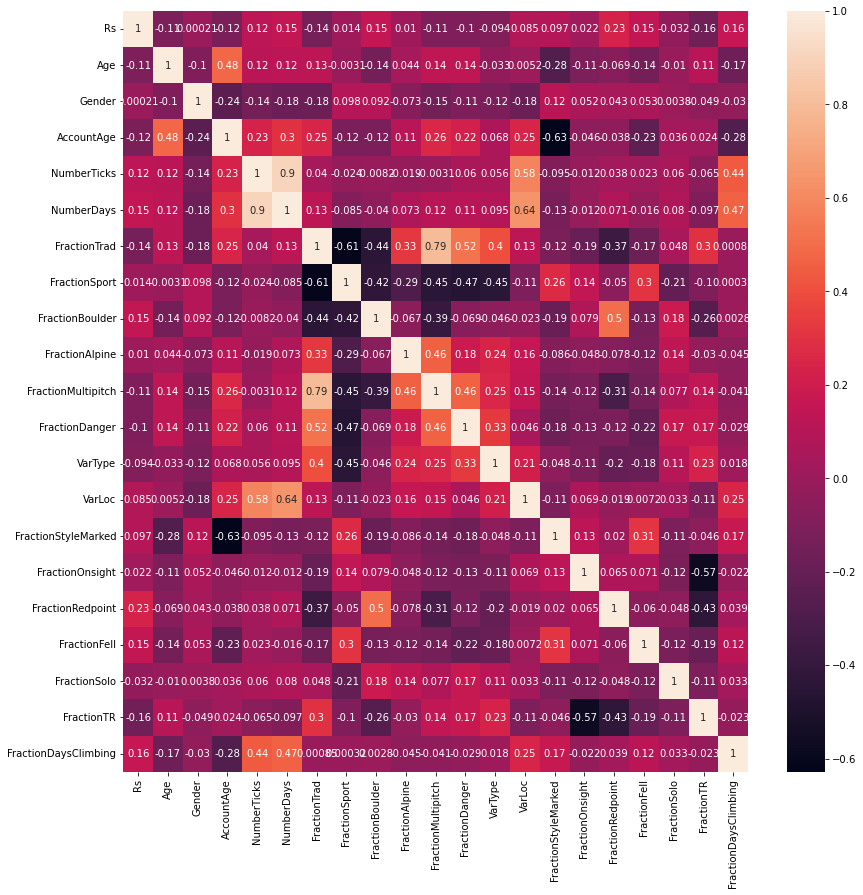

In [65]:
corrmat = df.corr()
plt.figure(figsize=(14,14))
sns.heatmap(df[corrmat.index].corr(),annot=True)


We can get an idea here of what features are probably going to be the most important in our model. Also, there are some features which are correlated with each other. Decision trees can handle multicollinearity, but we should still think about what features we are using and why. Here is a description of what information each feature is giving us:<br/>

`TickAge`: indicates the total amount of time that ticking has been happening. This is a proxy for amount of time climbing, since even if the tick numbers are low in this time interval, the user could be gym climbing a lot.<br/>
`NumberTicks`: indicates the amount of outdoor climbing a user has done over the lifetime of their profile. This is a proxy for total mileage on outdoor climbs<br/>
`NumberDays`: Number of unique days spent climbing (logged in ticks). This is different than NumberTicks because people who focus on climbing very hard things can have a low NumberDay vs NumberTicks relative to someone who climbs a high volume of easy things. <br/>
`FractionDaysClimbing`: This is a proxy for how "obsessed" someone is with climbing, since a very old account with relatively infrequent outdoor climbing days can have large values for Nticks and Ndays, but will have a small FractionDaysClimbing. <br/>

`FractionTrad`, `FractionSport`, `FractionBoulder`, `FractionAlpine`:<br/>
These are simply the fraction of total ticks for each style. These won't sum to 1 for every user since we don't include types outside of trad/sport/boulder/alpine, and since the degree collinearity depends on the specific user, we'll keep all of these and let the tree splitting deal with picking the right feature for each record. <br/>

`FractionMultipitch`: Fraction of ticks that are >1 pitch. This is highly correlated to `FractionTrad` since many more trad climbs are multipitches compared to sport climbs. However, users will typically climb easier multipitch trad climbs than single pitch trad climbs, so this will contain different information than `FractionTrad`<br/>

`VarType` and `VarLoc`: Standard deviation an integer encoding of the route types and number of different loctions with routes ticked. `VarType` is a weighted average of the fraction of ticks that are a given style, but since we're not including every style here, this contains unique information for some users. `VarLoc` tends to increase with climbing age, but not perfectly. <br/>

`FractionStyleMarked`, `FractionOnsight`, `FractionRedpoint`, `FractionFell`, `FracitonSolo`, `FractionTR`:<br/>
These are all related to the styles in which a user ticks something (and for `FractionStyleMarked`, the propensity of the user to actually mark styles on ticks). For roped climbing we're not including Flashing since it's very similar to onsighting and since bouldering is a small portion of users tick logs we're ignoring bouldering styles. 





We'll split the data into features and response:

In [66]:
#Split data into features and response
X=df.drop('Rs',axis=1)
y=df['Rs'].values
y=y+1.1 #make all response values > 0

## Choosing hyperparameters

Now we need to figure out our hyperparameters for the LightGBM model. To do this we'll use the optuna package which is a tool for scanning a large hyperparameter space to optimize an objective function. The function we will use is the mean MSE in 5-fold cross-validation. For this dataset, our focus is on interpretting the model to understand the factors that influence progression, so we're not too worried aout overfitting. We'll scan a parameter range that will produce fine trees. 

In [67]:
#Define objective function for optuna
def objective(trial, X, y):
    
    #Parameter grid to scan
    param_grid = {
        "n_estimators":trial.suggest_int("n_estimators", 2000, 7000, step=200), 
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 2000, 4000, step=200),
        "max_depth": trial.suggest_int("max_depth", 7, 10),
        'min_gain_to_split': trial.suggest_float("min_gain_to_split", 0.001, 0.1),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 0, 10, step=1),
        "min_sum_hessian_in_leaf": trial.suggest_int("min_sum_hessian_in_leaf", 0, 1, step=1),
        "lambda_l1": 0,
        "lambda_l2": 0,
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 0.9, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.75, 0.95, step=0.05)
    }

    #Cross validation
    cv = KFold(n_splits=5)
    cv_scores = np.empty(5)
    
    for i, (itrain, itest) in enumerate(cv.split(X, y)):
        #Split into training/test sets
        X_train, X_test = X.iloc[itrain], X.iloc[itest] 
        y_train, y_test = y[itrain], y[itest] 

        model = lgbm.LGBMRegressor(**param_grid) #Define regression model
        
        #Fit model
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="l2",
            early_stopping_rounds=100,
            callbacks=[LightGBMPruningCallback(trial, "l2")] 
        )
        
        #Make predictions and calculate MSE score 
        predictions = model.predict(X_test)
        cv_scores[i] = mean_squared_error(y_test, predictions)

    return np.mean(cv_scores)

Now we can actually run our optimizer to find the best hyperparameters

In [68]:
study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=15)

#Print best parameters
study.best_params
print('Best RMSE: '+str(study.best_value)+'\n')
print('Best parameters:')
for key in study.best_params.keys():
    print(key+': '+str(study.best_params[key]))

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_gain_to_split is set=0.03450095599167091, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03450095599167091
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's l2: 0.0992757
Training unt

The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step

[2]	valid_0's l2: 0.0960285
[3]	valid_0's l2: 0.0945098
[4]	valid_0's l2: 0.0936648
[5]	valid_0's l2: 0.0927577
[6]	valid_0's l2: 0.0917559
[7]	valid_0's l2: 0.0910892
[8]	valid_0's l2: 0.090383
[9]	valid_0's l2: 0.0898701
[10]	valid_0's l2: 0.089139
[11]	valid_0's l2: 0.0887716
[12]	valid_0's l2: 0.0883137
[13]	valid_0's l2: 0.0881683
[14]	valid_0's l2: 0.0878791
[15]	valid_0's l2: 0.0876566
[16]	valid_0's l2: 0.0874308
[17]	valid_0's l2: 0.0871218
[18]	valid_0's l2: 0.086986
[19]	valid_0's l2: 0.0867559
[20]	valid_0's l2: 0.0865386
[21]	valid_0's l2: 0.0865
[22]	valid_0's l2: 0.0864188
[23]	valid_0's l2: 0.0863251
[24]	valid_0's l2: 0.0861591
[25]	valid_0's l2: 0.0861407
[26]	valid_0's l2: 0.0861233
[27]	valid_0's l2: 0.0861401
[28]	valid_0's l2: 0.0861133


The reported value is ignored because this `step` 28 is already reported.
The reported value is ignored because this `step` 29 is already reported.
The reported value is ignored because this `step` 30 is already reported.
The reported value is ignored because this `step` 31 is already reported.
The reported value is ignored because this `step` 32 is already reported.
The reported value is ignored because this `step` 33 is already reported.
The reported value is ignored because this `step` 34 is already reported.
The reported value is ignored because this `step` 35 is already reported.
The reported value is ignored because this `step` 36 is already reported.
The reported value is ignored because this `step` 37 is already reported.
The reported value is ignored because this `step` 38 is already reported.
The reported value is ignored because this `step` 39 is already reported.
The reported value is ignored because this `step` 40 is already reported.
The reported value is ignored because 

[29]	valid_0's l2: 0.0859926
[30]	valid_0's l2: 0.0861197
[31]	valid_0's l2: 0.0862478
[32]	valid_0's l2: 0.0862452
[33]	valid_0's l2: 0.0862435
[34]	valid_0's l2: 0.086162
[35]	valid_0's l2: 0.0862056
[36]	valid_0's l2: 0.0863026
[37]	valid_0's l2: 0.0862946
[38]	valid_0's l2: 0.0863232
[39]	valid_0's l2: 0.0863709
[40]	valid_0's l2: 0.0863546
[41]	valid_0's l2: 0.086257
[42]	valid_0's l2: 0.0861897
[43]	valid_0's l2: 0.0863043
[44]	valid_0's l2: 0.0863101
[45]	valid_0's l2: 0.0863077
[46]	valid_0's l2: 0.0863662
[47]	valid_0's l2: 0.086437
[48]	valid_0's l2: 0.0864184
[49]	valid_0's l2: 0.0864527
[50]	valid_0's l2: 0.0865678
[51]	valid_0's l2: 0.0865627
[52]	valid_0's l2: 0.0866581
[53]	valid_0's l2: 0.0866468
[54]	valid_0's l2: 0.0867503
[55]	valid_0's l2: 0.0866137
[56]	valid_0's l2: 0.0867022
[57]	valid_0's l2: 0.0868385
[58]	valid_0's l2: 0.0868099
[59]	valid_0's l2: 0.0867247
[60]	valid_0's l2: 0.0867022
[61]	valid_0's l2: 0.0867044
[62]	valid_0's l2: 0.0867622


The reported value is ignored because this `step` 62 is already reported.
The reported value is ignored because this `step` 63 is already reported.
The reported value is ignored because this `step` 64 is already reported.
The reported value is ignored because this `step` 65 is already reported.
The reported value is ignored because this `step` 66 is already reported.
The reported value is ignored because this `step` 67 is already reported.
The reported value is ignored because this `step` 68 is already reported.
The reported value is ignored because this `step` 69 is already reported.
The reported value is ignored because this `step` 70 is already reported.
The reported value is ignored because this `step` 71 is already reported.
The reported value is ignored because this `step` 72 is already reported.
The reported value is ignored because this `step` 73 is already reported.
The reported value is ignored because this `step` 74 is already reported.
The reported value is ignored because 

[63]	valid_0's l2: 0.0867665
[64]	valid_0's l2: 0.0867841
[65]	valid_0's l2: 0.0868147
[66]	valid_0's l2: 0.0869355
[67]	valid_0's l2: 0.0870051
[68]	valid_0's l2: 0.0870235
[69]	valid_0's l2: 0.0869964
[70]	valid_0's l2: 0.0870598
[71]	valid_0's l2: 0.0870669
[72]	valid_0's l2: 0.0871379
[73]	valid_0's l2: 0.0872529
[74]	valid_0's l2: 0.0873659
[75]	valid_0's l2: 0.087416
[76]	valid_0's l2: 0.087496
[77]	valid_0's l2: 0.0876386
[78]	valid_0's l2: 0.0877452
[79]	valid_0's l2: 0.0878664
[80]	valid_0's l2: 0.0878952
[81]	valid_0's l2: 0.0879494
[82]	valid_0's l2: 0.0879702
[83]	valid_0's l2: 0.0880049
[84]	valid_0's l2: 0.0880202
[85]	valid_0's l2: 0.0880641
[86]	valid_0's l2: 0.0881127
[87]	valid_0's l2: 0.0880962
[88]	valid_0's l2: 0.0881398
[89]	valid_0's l2: 0.0881791
[90]	valid_0's l2: 0.08823
[91]	valid_0's l2: 0.0882685


The reported value is ignored because this `step` 92 is already reported.
The reported value is ignored because this `step` 93 is already reported.
The reported value is ignored because this `step` 94 is already reported.
The reported value is ignored because this `step` 95 is already reported.
The reported value is ignored because this `step` 96 is already reported.
The reported value is ignored because this `step` 97 is already reported.
The reported value is ignored because this `step` 98 is already reported.
The reported value is ignored because this `step` 99 is already reported.
The reported value is ignored because this `step` 100 is already reported.
The reported value is ignored because this `step` 101 is already reported.
The reported value is ignored because this `step` 102 is already reported.
The reported value is ignored because this `step` 103 is already reported.
The reported value is ignored because this `step` 104 is already reported.
The reported value is ignored bec

[92]	valid_0's l2: 0.0882577
[93]	valid_0's l2: 0.0881771
[94]	valid_0's l2: 0.0882456
[95]	valid_0's l2: 0.0882506
[96]	valid_0's l2: 0.0882156
[97]	valid_0's l2: 0.0882263
[98]	valid_0's l2: 0.0881752
[99]	valid_0's l2: 0.0881937
[100]	valid_0's l2: 0.0882288
[101]	valid_0's l2: 0.0882305
[102]	valid_0's l2: 0.0882593
[103]	valid_0's l2: 0.0882626
[104]	valid_0's l2: 0.0883202
[105]	valid_0's l2: 0.0883264
[106]	valid_0's l2: 0.0883706
[107]	valid_0's l2: 0.0883593
[108]	valid_0's l2: 0.0883956
[109]	valid_0's l2: 0.088401
[110]	valid_0's l2: 0.0884189
[111]	valid_0's l2: 0.0884264
[112]	valid_0's l2: 0.0885
[113]	valid_0's l2: 0.0885254
[114]	valid_0's l2: 0.0885234
[115]	valid_0's l2: 0.0885126
[116]	valid_0's l2: 0.0884902
[117]	valid_0's l2: 0.0885023
[118]	valid_0's l2: 0.0885218
[119]	valid_0's l2: 0.088496
[120]	valid_0's l2: 0.0885131
[121]	valid_0's l2: 0.0885286
[122]	valid_0's l2: 0.0885267
[123]	valid_0's l2: 0.0885705
[124]	valid_0's l2: 0.0886013
[125]	valid_0's l2: 0.0

The reported value is ignored because this `step` 125 is already reported.
The reported value is ignored because this `step` 126 is already reported.
The reported value is ignored because this `step` 127 is already reported.
The reported value is ignored because this `step` 128 is already reported.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this 

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_gain_to_split is set=0.03450095599167091, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03450095599167091
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's l2: 0.101648
Training unti

The reported value is ignored because this `step` 15 is already reported.
The reported value is ignored because this `step` 16 is already reported.
The reported value is ignored because this `step` 17 is already reported.
The reported value is ignored because this `step` 18 is already reported.
The reported value is ignored because this `step` 19 is already reported.
The reported value is ignored because this `step` 20 is already reported.
The reported value is ignored because this `step` 21 is already reported.
The reported value is ignored because this `step` 22 is already reported.
The reported value is ignored because this `step` 23 is already reported.
The reported value is ignored because this `step` 24 is already reported.
The reported value is ignored because this `step` 25 is already reported.
The reported value is ignored because this `step` 26 is already reported.
The reported value is ignored because this `step` 27 is already reported.
The reported value is ignored because 

[21]	valid_0's l2: 0.0901389
[22]	valid_0's l2: 0.0900828
[23]	valid_0's l2: 0.0899681
[24]	valid_0's l2: 0.0899933
[25]	valid_0's l2: 0.0898514
[26]	valid_0's l2: 0.0898962
[27]	valid_0's l2: 0.0898997
[28]	valid_0's l2: 0.0899743
[29]	valid_0's l2: 0.0899691
[30]	valid_0's l2: 0.0898738
[31]	valid_0's l2: 0.0899405
[32]	valid_0's l2: 0.090015
[33]	valid_0's l2: 0.0900166
[34]	valid_0's l2: 0.089963
[35]	valid_0's l2: 0.0899754
[36]	valid_0's l2: 0.0899705
[37]	valid_0's l2: 0.0901127
[38]	valid_0's l2: 0.0900806
[39]	valid_0's l2: 0.0900892
[40]	valid_0's l2: 0.0901413
[41]	valid_0's l2: 0.0901287
[42]	valid_0's l2: 0.0900793
[43]	valid_0's l2: 0.0901247
[44]	valid_0's l2: 0.0900337
[45]	valid_0's l2: 0.0899988
[46]	valid_0's l2: 0.0900507
[47]	valid_0's l2: 0.0900625
[48]	valid_0's l2: 0.0900907
[49]	valid_0's l2: 0.0899965
[50]	valid_0's l2: 0.0900086
[51]	valid_0's l2: 0.0900676
[52]	valid_0's l2: 0.0901283
[53]	valid_0's l2: 0.0901082
[54]	valid_0's l2: 0.0901461


The reported value is ignored because this `step` 47 is already reported.
The reported value is ignored because this `step` 48 is already reported.
The reported value is ignored because this `step` 49 is already reported.
The reported value is ignored because this `step` 50 is already reported.
The reported value is ignored because this `step` 51 is already reported.
The reported value is ignored because this `step` 52 is already reported.
The reported value is ignored because this `step` 53 is already reported.
The reported value is ignored because this `step` 54 is already reported.
The reported value is ignored because this `step` 55 is already reported.
The reported value is ignored because this `step` 56 is already reported.
The reported value is ignored because this `step` 57 is already reported.
The reported value is ignored because this `step` 58 is already reported.
The reported value is ignored because this `step` 59 is already reported.
The reported value is ignored because 

[55]	valid_0's l2: 0.0900284
[56]	valid_0's l2: 0.0900723
[57]	valid_0's l2: 0.0900749
[58]	valid_0's l2: 0.0899954
[59]	valid_0's l2: 0.0900127
[60]	valid_0's l2: 0.0900009
[61]	valid_0's l2: 0.0900351
[62]	valid_0's l2: 0.089981
[63]	valid_0's l2: 0.0899808
[64]	valid_0's l2: 0.0900104
[65]	valid_0's l2: 0.0900964
[66]	valid_0's l2: 0.0901098
[67]	valid_0's l2: 0.0901476
[68]	valid_0's l2: 0.0901543
[69]	valid_0's l2: 0.090236
[70]	valid_0's l2: 0.0902203
[71]	valid_0's l2: 0.0902309
[72]	valid_0's l2: 0.0902577
[73]	valid_0's l2: 0.0902999
[74]	valid_0's l2: 0.0903079
[75]	valid_0's l2: 0.0902671
[76]	valid_0's l2: 0.0902675
[77]	valid_0's l2: 0.0902187
[78]	valid_0's l2: 0.0902395
[79]	valid_0's l2: 0.0903664
[80]	valid_0's l2: 0.0903591
[81]	valid_0's l2: 0.0903482
[82]	valid_0's l2: 0.0903431
[83]	valid_0's l2: 0.0903916
[84]	valid_0's l2: 0.090414
[85]	valid_0's l2: 0.0904255
[86]	valid_0's l2: 0.0904817
[87]	valid_0's l2: 0.0904978
[88]	valid_0's l2: 0.0905257
[89]	valid_0's l2

The reported value is ignored because this `step` 88 is already reported.
The reported value is ignored because this `step` 89 is already reported.
The reported value is ignored because this `step` 90 is already reported.
The reported value is ignored because this `step` 91 is already reported.
The reported value is ignored because this `step` 92 is already reported.
The reported value is ignored because this `step` 93 is already reported.
The reported value is ignored because this `step` 94 is already reported.
The reported value is ignored because this `step` 95 is already reported.
The reported value is ignored because this `step` 96 is already reported.
The reported value is ignored because this `step` 97 is already reported.
The reported value is ignored because this `step` 98 is already reported.
The reported value is ignored because this `step` 99 is already reported.
The reported value is ignored because this `step` 100 is already reported.
The reported value is ignored because

[97]	valid_0's l2: 0.0904713
[98]	valid_0's l2: 0.0904949
[99]	valid_0's l2: 0.0905089
[100]	valid_0's l2: 0.0904993
[101]	valid_0's l2: 0.0905169
[102]	valid_0's l2: 0.0905379
[103]	valid_0's l2: 0.0905636
[104]	valid_0's l2: 0.0905933
[105]	valid_0's l2: 0.0906788
[106]	valid_0's l2: 0.0906989
[107]	valid_0's l2: 0.0907139
[108]	valid_0's l2: 0.0906969
[109]	valid_0's l2: 0.090789
[110]	valid_0's l2: 0.0908057
[111]	valid_0's l2: 0.0908074
[112]	valid_0's l2: 0.0908356
[113]	valid_0's l2: 0.0907985
[114]	valid_0's l2: 0.0907734
[115]	valid_0's l2: 0.0907898
[116]	valid_0's l2: 0.0907658
[117]	valid_0's l2: 0.0907577
[118]	valid_0's l2: 0.0908111
[119]	valid_0's l2: 0.0908898
[120]	valid_0's l2: 0.0909732
[121]	valid_0's l2: 0.0909813
[122]	valid_0's l2: 0.0909638
[123]	valid_0's l2: 0.0909517
[124]	valid_0's l2: 0.0909978
[125]	valid_0's l2: 0.0909859
Early stopping, best iteration is:
[25]	valid_0's l2: 0.0898514
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0

The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step` 13 is already reported.
The reported value is ignored because this `ste

[5]	valid_0's l2: 0.106759
[6]	valid_0's l2: 0.105822
[7]	valid_0's l2: 0.104885
[8]	valid_0's l2: 0.104192
[9]	valid_0's l2: 0.103388
[10]	valid_0's l2: 0.102741
[11]	valid_0's l2: 0.102336
[12]	valid_0's l2: 0.101766
[13]	valid_0's l2: 0.101363
[14]	valid_0's l2: 0.101334
[15]	valid_0's l2: 0.101004
[16]	valid_0's l2: 0.100816
[17]	valid_0's l2: 0.100772
[18]	valid_0's l2: 0.100639
[19]	valid_0's l2: 0.100639
[20]	valid_0's l2: 0.100511
[21]	valid_0's l2: 0.100468
[22]	valid_0's l2: 0.100475
[23]	valid_0's l2: 0.100281
[24]	valid_0's l2: 0.100177
[25]	valid_0's l2: 0.100191
[26]	valid_0's l2: 0.100222
[27]	valid_0's l2: 0.100214
[28]	valid_0's l2: 0.100141
[29]	valid_0's l2: 0.100177
[30]	valid_0's l2: 0.100228
[31]	valid_0's l2: 0.100198
[32]	valid_0's l2: 0.100113
[33]	valid_0's l2: 0.100173
[34]	valid_0's l2: 0.100301


The reported value is ignored because this `step` 28 is already reported.
The reported value is ignored because this `step` 29 is already reported.
The reported value is ignored because this `step` 30 is already reported.
The reported value is ignored because this `step` 31 is already reported.
The reported value is ignored because this `step` 32 is already reported.
The reported value is ignored because this `step` 33 is already reported.
The reported value is ignored because this `step` 34 is already reported.
The reported value is ignored because this `step` 35 is already reported.
The reported value is ignored because this `step` 36 is already reported.
The reported value is ignored because this `step` 37 is already reported.
The reported value is ignored because this `step` 38 is already reported.
The reported value is ignored because this `step` 39 is already reported.
The reported value is ignored because this `step` 40 is already reported.
The reported value is ignored because 

[35]	valid_0's l2: 0.10013
[36]	valid_0's l2: 0.100086
[37]	valid_0's l2: 0.0999906
[38]	valid_0's l2: 0.100006
[39]	valid_0's l2: 0.099975
[40]	valid_0's l2: 0.0999317
[41]	valid_0's l2: 0.100076
[42]	valid_0's l2: 0.100134
[43]	valid_0's l2: 0.100177
[44]	valid_0's l2: 0.100154
[45]	valid_0's l2: 0.100219
[46]	valid_0's l2: 0.100306
[47]	valid_0's l2: 0.100378
[48]	valid_0's l2: 0.100355
[49]	valid_0's l2: 0.100493
[50]	valid_0's l2: 0.100544
[51]	valid_0's l2: 0.100655
[52]	valid_0's l2: 0.100735
[53]	valid_0's l2: 0.100933
[54]	valid_0's l2: 0.100926
[55]	valid_0's l2: 0.100981
[56]	valid_0's l2: 0.101003
[57]	valid_0's l2: 0.101093
[58]	valid_0's l2: 0.10114
[59]	valid_0's l2: 0.101213
[60]	valid_0's l2: 0.101243
[61]	valid_0's l2: 0.101366
[62]	valid_0's l2: 0.101396
[63]	valid_0's l2: 0.101456
[64]	valid_0's l2: 0.101536
[65]	valid_0's l2: 0.101704
[66]	valid_0's l2: 0.101685
[67]	valid_0's l2: 0.101671
[68]	valid_0's l2: 0.101631
[69]	valid_0's l2: 0.10157
[70]	valid_0's l2: 0.

The reported value is ignored because this `step` 65 is already reported.
The reported value is ignored because this `step` 66 is already reported.
The reported value is ignored because this `step` 67 is already reported.
The reported value is ignored because this `step` 68 is already reported.
The reported value is ignored because this `step` 69 is already reported.
The reported value is ignored because this `step` 70 is already reported.
The reported value is ignored because this `step` 71 is already reported.
The reported value is ignored because this `step` 72 is already reported.
The reported value is ignored because this `step` 73 is already reported.
The reported value is ignored because this `step` 74 is already reported.
The reported value is ignored because this `step` 75 is already reported.
The reported value is ignored because this `step` 76 is already reported.
The reported value is ignored because this `step` 77 is already reported.
The reported value is ignored because 

[72]	valid_0's l2: 0.101665
[73]	valid_0's l2: 0.101644
[74]	valid_0's l2: 0.101664
[75]	valid_0's l2: 0.101684
[76]	valid_0's l2: 0.101742
[77]	valid_0's l2: 0.101763
[78]	valid_0's l2: 0.10179
[79]	valid_0's l2: 0.101833
[80]	valid_0's l2: 0.101808
[81]	valid_0's l2: 0.101865
[82]	valid_0's l2: 0.101928
[83]	valid_0's l2: 0.101894
[84]	valid_0's l2: 0.101956
[85]	valid_0's l2: 0.101956
[86]	valid_0's l2: 0.10194
[87]	valid_0's l2: 0.101941
[88]	valid_0's l2: 0.101991
[89]	valid_0's l2: 0.102012
[90]	valid_0's l2: 0.102061
[91]	valid_0's l2: 0.10205
[92]	valid_0's l2: 0.102078
[93]	valid_0's l2: 0.102112
[94]	valid_0's l2: 0.102201
[95]	valid_0's l2: 0.102257
[96]	valid_0's l2: 0.10225
[97]	valid_0's l2: 0.102308
[98]	valid_0's l2: 0.102373
[99]	valid_0's l2: 0.102406
[100]	valid_0's l2: 0.102464
[101]	valid_0's l2: 0.102466
[102]	valid_0's l2: 0.102422
[103]	valid_0's l2: 0.10254
[104]	valid_0's l2: 0.102541
[105]	valid_0's l2: 0.102568
[106]	valid_0's l2: 0.102607
[107]	valid_0's l2

The reported value is ignored because this `step` 105 is already reported.
The reported value is ignored because this `step` 106 is already reported.
The reported value is ignored because this `step` 107 is already reported.
The reported value is ignored because this `step` 108 is already reported.
The reported value is ignored because this `step` 109 is already reported.
The reported value is ignored because this `step` 110 is already reported.
The reported value is ignored because this `step` 111 is already reported.
The reported value is ignored because this `step` 112 is already reported.
The reported value is ignored because this `step` 113 is already reported.
The reported value is ignored because this `step` 114 is already reported.
The reported value is ignored because this `step` 115 is already reported.
The reported value is ignored because this `step` 116 is already reported.
The reported value is ignored because this `step` 117 is already reported.
The reported value is ign

[114]	valid_0's l2: 0.102944
[115]	valid_0's l2: 0.102949
[116]	valid_0's l2: 0.102944
[117]	valid_0's l2: 0.102942
[118]	valid_0's l2: 0.102963
[119]	valid_0's l2: 0.10298
[120]	valid_0's l2: 0.102986
[121]	valid_0's l2: 0.102992
[122]	valid_0's l2: 0.103026
[123]	valid_0's l2: 0.102964
[124]	valid_0's l2: 0.102988
[125]	valid_0's l2: 0.102962
[126]	valid_0's l2: 0.102964
[127]	valid_0's l2: 0.10299
[128]	valid_0's l2: 0.10302
[129]	valid_0's l2: 0.103042
[130]	valid_0's l2: 0.103039
[131]	valid_0's l2: 0.103088
[132]	valid_0's l2: 0.103094
[133]	valid_0's l2: 0.10312
[134]	valid_0's l2: 0.103065
[135]	valid_0's l2: 0.103071
[136]	valid_0's l2: 0.103081
[137]	valid_0's l2: 0.103105
[138]	valid_0's l2: 0.103107
[139]	valid_0's l2: 0.103124
[140]	valid_0's l2: 0.103128
Early stopping, best iteration is:
[40]	valid_0's l2: 0.0999317
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_

The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step` 13 is already reported.
The reported value is ignored because this `step` 14 is already reported.
The reported value is ignored because this `step` 15 is already reported.
The reported value is ignored because this `step` 16 is already reported.
The reported value is ignored because this `step` 17 is already reported.
The reported value is ignored because this 

[9]	valid_0's l2: 0.108148
[10]	valid_0's l2: 0.107572
[11]	valid_0's l2: 0.107008
[12]	valid_0's l2: 0.106614
[13]	valid_0's l2: 0.106247
[14]	valid_0's l2: 0.106198
[15]	valid_0's l2: 0.106057
[16]	valid_0's l2: 0.106021
[17]	valid_0's l2: 0.105944
[18]	valid_0's l2: 0.105931
[19]	valid_0's l2: 0.105789
[20]	valid_0's l2: 0.105556
[21]	valid_0's l2: 0.105504
[22]	valid_0's l2: 0.1055
[23]	valid_0's l2: 0.105527
[24]	valid_0's l2: 0.105328
[25]	valid_0's l2: 0.105175
[26]	valid_0's l2: 0.105084
[27]	valid_0's l2: 0.104855
[28]	valid_0's l2: 0.104705
[29]	valid_0's l2: 0.104801
[30]	valid_0's l2: 0.104725
[31]	valid_0's l2: 0.104753
[32]	valid_0's l2: 0.104843
[33]	valid_0's l2: 0.104937
[34]	valid_0's l2: 0.104829
[35]	valid_0's l2: 0.104844
[36]	valid_0's l2: 0.104868
[37]	valid_0's l2: 0.10486


The reported value is ignored because this `step` 34 is already reported.
The reported value is ignored because this `step` 35 is already reported.
The reported value is ignored because this `step` 36 is already reported.
The reported value is ignored because this `step` 37 is already reported.
The reported value is ignored because this `step` 38 is already reported.
The reported value is ignored because this `step` 39 is already reported.
The reported value is ignored because this `step` 40 is already reported.
The reported value is ignored because this `step` 41 is already reported.
The reported value is ignored because this `step` 42 is already reported.
The reported value is ignored because this `step` 43 is already reported.
The reported value is ignored because this `step` 44 is already reported.
The reported value is ignored because this `step` 45 is already reported.
The reported value is ignored because this `step` 46 is already reported.
The reported value is ignored because 

[38]	valid_0's l2: 0.104841
[39]	valid_0's l2: 0.104926
[40]	valid_0's l2: 0.104874
[41]	valid_0's l2: 0.104881
[42]	valid_0's l2: 0.104968
[43]	valid_0's l2: 0.105041
[44]	valid_0's l2: 0.104971
[45]	valid_0's l2: 0.105025
[46]	valid_0's l2: 0.105096
[47]	valid_0's l2: 0.105183
[48]	valid_0's l2: 0.105251
[49]	valid_0's l2: 0.105349
[50]	valid_0's l2: 0.105332
[51]	valid_0's l2: 0.105427
[52]	valid_0's l2: 0.10563
[53]	valid_0's l2: 0.105617
[54]	valid_0's l2: 0.105609
[55]	valid_0's l2: 0.105551
[56]	valid_0's l2: 0.105522
[57]	valid_0's l2: 0.105456
[58]	valid_0's l2: 0.105467
[59]	valid_0's l2: 0.105404
[60]	valid_0's l2: 0.10541
[61]	valid_0's l2: 0.105423
[62]	valid_0's l2: 0.105424
[63]	valid_0's l2: 0.10547
[64]	valid_0's l2: 0.105589
[65]	valid_0's l2: 0.105766
[66]	valid_0's l2: 0.105783
[67]	valid_0's l2: 0.105773
[68]	valid_0's l2: 0.105873
[69]	valid_0's l2: 0.105859
[70]	valid_0's l2: 0.105967
[71]	valid_0's l2: 0.106105
[72]	valid_0's l2: 0.106065
[73]	valid_0's l2: 0.10

The reported value is ignored because this `step` 70 is already reported.
The reported value is ignored because this `step` 71 is already reported.
The reported value is ignored because this `step` 72 is already reported.
The reported value is ignored because this `step` 73 is already reported.
The reported value is ignored because this `step` 74 is already reported.
The reported value is ignored because this `step` 75 is already reported.
The reported value is ignored because this `step` 76 is already reported.
The reported value is ignored because this `step` 77 is already reported.
The reported value is ignored because this `step` 78 is already reported.
The reported value is ignored because this `step` 79 is already reported.
The reported value is ignored because this `step` 80 is already reported.
The reported value is ignored because this `step` 81 is already reported.
The reported value is ignored because this `step` 82 is already reported.
The reported value is ignored because 

[74]	valid_0's l2: 0.106166
[75]	valid_0's l2: 0.106329
[76]	valid_0's l2: 0.106257
[77]	valid_0's l2: 0.106299
[78]	valid_0's l2: 0.10634
[79]	valid_0's l2: 0.106333
[80]	valid_0's l2: 0.106366
[81]	valid_0's l2: 0.106459
[82]	valid_0's l2: 0.106495
[83]	valid_0's l2: 0.106505
[84]	valid_0's l2: 0.10646
[85]	valid_0's l2: 0.106415
[86]	valid_0's l2: 0.106393
[87]	valid_0's l2: 0.1064
[88]	valid_0's l2: 0.106388
[89]	valid_0's l2: 0.106367
[90]	valid_0's l2: 0.106432
[91]	valid_0's l2: 0.106411
[92]	valid_0's l2: 0.106418
[93]	valid_0's l2: 0.106363
[94]	valid_0's l2: 0.106375
[95]	valid_0's l2: 0.106359
[96]	valid_0's l2: 0.106406
[97]	valid_0's l2: 0.106367
[98]	valid_0's l2: 0.106381
[99]	valid_0's l2: 0.106377
[100]	valid_0's l2: 0.106295
[101]	valid_0's l2: 0.106348
[102]	valid_0's l2: 0.106346
[103]	valid_0's l2: 0.106311
[104]	valid_0's l2: 0.106338
[105]	valid_0's l2: 0.106378
[106]	valid_0's l2: 0.106409
[107]	valid_0's l2: 0.106421
[108]	valid_0's l2: 0.106457
[109]	valid_0's

The reported value is ignored because this `step` 113 is already reported.
The reported value is ignored because this `step` 114 is already reported.
The reported value is ignored because this `step` 115 is already reported.
The reported value is ignored because this `step` 116 is already reported.
The reported value is ignored because this `step` 117 is already reported.
The reported value is ignored because this `step` 118 is already reported.
The reported value is ignored because this `step` 119 is already reported.
The reported value is ignored because this `step` 120 is already reported.
The reported value is ignored because this `step` 121 is already reported.
The reported value is ignored because this `step` 122 is already reported.
The reported value is ignored because this `step` 123 is already reported.
The reported value is ignored because this `step` 124 is already reported.
The reported value is ignored because this `step` 125 is already reported.
The reported value is ign

[118]	valid_0's l2: 0.106582
[119]	valid_0's l2: 0.106563
[120]	valid_0's l2: 0.106596
[121]	valid_0's l2: 0.106658
[122]	valid_0's l2: 0.106641
[123]	valid_0's l2: 0.106686
[124]	valid_0's l2: 0.106685
[125]	valid_0's l2: 0.106686
[126]	valid_0's l2: 0.106689
[127]	valid_0's l2: 0.106678
[128]	valid_0's l2: 0.106649
Early stopping, best iteration is:
[28]	valid_0's l2: 0.104705
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_gain_to_split is set=0.019583025729270856, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.019583025729270856
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_s

[268]	valid_0's l2: 0.0817704
[269]	valid_0's l2: 0.081758
[270]	valid_0's l2: 0.0817598
[271]	valid_0's l2: 0.0817757
[272]	valid_0's l2: 0.0817727
[273]	valid_0's l2: 0.081763
[274]	valid_0's l2: 0.0817703
[275]	valid_0's l2: 0.0817715
[276]	valid_0's l2: 0.0817831
Early stopping, best iteration is:
[176]	valid_0's l2: 0.0813897
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_gain_to_split is set=0.019583025729270856, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.019583025729270856
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[LightGBM] [Warning] bagging

The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step


[8]	valid_0's l2: 0.0948199
[9]	valid_0's l2: 0.0944111
[10]	valid_0's l2: 0.0938815
[11]	valid_0's l2: 0.093521
[12]	valid_0's l2: 0.0930524
[13]	valid_0's l2: 0.0926996
[14]	valid_0's l2: 0.0923218
[15]	valid_0's l2: 0.0919902
[16]	valid_0's l2: 0.0916784
[17]	valid_0's l2: 0.0913638
[18]	valid_0's l2: 0.0911071
[19]	valid_0's l2: 0.0908173
[20]	valid_0's l2: 0.0905802
[21]	valid_0's l2: 0.0903616
[22]	valid_0's l2: 0.0901196
[23]	valid_0's l2: 0.0899225
[24]	valid_0's l2: 0.0897334
[25]	valid_0's l2: 0.0895098
[26]	valid_0's l2: 0.0893022
[27]	valid_0's l2: 0.0891406
[28]	valid_0's l2: 0.0889499
[29]	valid_0's l2: 0.0887553
[30]	valid_0's l2: 0.0886251
[31]	valid_0's l2: 0.0884923
[32]	valid_0's l2: 0.0883475
[33]	valid_0's l2: 0.0882519
[34]	valid_0's l2: 0.0881077
[35]	valid_0's l2: 0.0879864
[36]	valid_0's l2: 0.0878916
[37]	valid_0's l2: 0.0877756
[38]	valid_0's l2: 0.0876801
[39]	valid_0's l2: 0.0875327
[40]	valid_0's l2: 0.0874355
[41]	valid_0's l2: 0.0873726
[42]	valid_0's l

The reported value is ignored because this `step` 36 is already reported.
The reported value is ignored because this `step` 37 is already reported.
The reported value is ignored because this `step` 38 is already reported.
The reported value is ignored because this `step` 39 is already reported.
The reported value is ignored because this `step` 40 is already reported.
The reported value is ignored because this `step` 41 is already reported.
The reported value is ignored because this `step` 42 is already reported.
The reported value is ignored because this `step` 43 is already reported.
The reported value is ignored because this `step` 44 is already reported.
The reported value is ignored because this `step` 45 is already reported.
The reported value is ignored because this `step` 46 is already reported.
The reported value is ignored because this `step` 47 is already reported.
The reported value is ignored because this `step` 48 is already reported.
The reported value is ignored because 

[44]	valid_0's l2: 0.0871785
[45]	valid_0's l2: 0.0871344
[46]	valid_0's l2: 0.0870772
[47]	valid_0's l2: 0.0870586
[48]	valid_0's l2: 0.0869483
[49]	valid_0's l2: 0.0868914
[50]	valid_0's l2: 0.0867904
[51]	valid_0's l2: 0.0868005
[52]	valid_0's l2: 0.0867503
[53]	valid_0's l2: 0.086704
[54]	valid_0's l2: 0.0866417
[55]	valid_0's l2: 0.0865646
[56]	valid_0's l2: 0.0865272
[57]	valid_0's l2: 0.086494
[58]	valid_0's l2: 0.0864598
[59]	valid_0's l2: 0.0864098
[60]	valid_0's l2: 0.0863927
[61]	valid_0's l2: 0.0863696
[62]	valid_0's l2: 0.0863148
[63]	valid_0's l2: 0.086263
[64]	valid_0's l2: 0.0862385
[65]	valid_0's l2: 0.0862467
[66]	valid_0's l2: 0.0861718
[67]	valid_0's l2: 0.0861485
[68]	valid_0's l2: 0.0860715
[69]	valid_0's l2: 0.0860738
[70]	valid_0's l2: 0.0860376
[71]	valid_0's l2: 0.086053
[72]	valid_0's l2: 0.0860196
[73]	valid_0's l2: 0.0860024
[74]	valid_0's l2: 0.085993
[75]	valid_0's l2: 0.0860001
[76]	valid_0's l2: 0.0860132
[77]	valid_0's l2: 0.0860096
[78]	valid_0's l2: 

The reported value is ignored because this `step` 79 is already reported.
The reported value is ignored because this `step` 80 is already reported.
The reported value is ignored because this `step` 81 is already reported.
The reported value is ignored because this `step` 82 is already reported.
The reported value is ignored because this `step` 83 is already reported.
The reported value is ignored because this `step` 84 is already reported.
The reported value is ignored because this `step` 85 is already reported.
The reported value is ignored because this `step` 86 is already reported.
The reported value is ignored because this `step` 87 is already reported.
The reported value is ignored because this `step` 88 is already reported.
The reported value is ignored because this `step` 89 is already reported.
The reported value is ignored because this `step` 90 is already reported.
The reported value is ignored because this `step` 91 is already reported.
The reported value is ignored because 

[87]	valid_0's l2: 0.0859366
[88]	valid_0's l2: 0.08596
[89]	valid_0's l2: 0.0859729
[90]	valid_0's l2: 0.085931
[91]	valid_0's l2: 0.0859088
[92]	valid_0's l2: 0.0859155
[93]	valid_0's l2: 0.0859376
[94]	valid_0's l2: 0.0859558
[95]	valid_0's l2: 0.0859313
[96]	valid_0's l2: 0.0859177
[97]	valid_0's l2: 0.0859099
[98]	valid_0's l2: 0.0859051
[99]	valid_0's l2: 0.0858902
[100]	valid_0's l2: 0.0858882
[101]	valid_0's l2: 0.0858617
[102]	valid_0's l2: 0.0858349
[103]	valid_0's l2: 0.0858117
[104]	valid_0's l2: 0.0857924
[105]	valid_0's l2: 0.0857815
[106]	valid_0's l2: 0.0857847
[107]	valid_0's l2: 0.085815
[108]	valid_0's l2: 0.0858342
[109]	valid_0's l2: 0.0858238
[110]	valid_0's l2: 0.0858129
[111]	valid_0's l2: 0.085833
[112]	valid_0's l2: 0.0858395
[113]	valid_0's l2: 0.0858492
[114]	valid_0's l2: 0.0858506
[115]	valid_0's l2: 0.0858367
[116]	valid_0's l2: 0.0858574
[117]	valid_0's l2: 0.0858546
[118]	valid_0's l2: 0.0858516
[119]	valid_0's l2: 0.0858491
[120]	valid_0's l2: 0.085844

The reported value is ignored because this `step` 130 is already reported.
The reported value is ignored because this `step` 131 is already reported.
The reported value is ignored because this `step` 132 is already reported.
The reported value is ignored because this `step` 133 is already reported.
The reported value is ignored because this `step` 134 is already reported.
The reported value is ignored because this `step` 135 is already reported.
The reported value is ignored because this `step` 136 is already reported.
The reported value is ignored because this `step` 137 is already reported.
The reported value is ignored because this `step` 138 is already reported.
The reported value is ignored because this `step` 139 is already reported.
The reported value is ignored because this `step` 140 is already reported.
The reported value is ignored because this `step` 141 is already reported.
The reported value is ignored because this `step` 142 is already reported.
The reported value is ign

[140]	valid_0's l2: 0.085717
[141]	valid_0's l2: 0.0856785
[142]	valid_0's l2: 0.0856878
[143]	valid_0's l2: 0.0857026
[144]	valid_0's l2: 0.0857152
[145]	valid_0's l2: 0.0856849
[146]	valid_0's l2: 0.0856609
[147]	valid_0's l2: 0.0856482
[148]	valid_0's l2: 0.0856911
[149]	valid_0's l2: 0.0856937
[150]	valid_0's l2: 0.0857378
[151]	valid_0's l2: 0.085741
[152]	valid_0's l2: 0.0857464
[153]	valid_0's l2: 0.0857258
[154]	valid_0's l2: 0.085723
[155]	valid_0's l2: 0.0857143
[156]	valid_0's l2: 0.085657
[157]	valid_0's l2: 0.0856581
[158]	valid_0's l2: 0.0856637
[159]	valid_0's l2: 0.0856945
[160]	valid_0's l2: 0.0856877
[161]	valid_0's l2: 0.0856914
[162]	valid_0's l2: 0.0857136
[163]	valid_0's l2: 0.0857314
[164]	valid_0's l2: 0.0857061
[165]	valid_0's l2: 0.0857373
[166]	valid_0's l2: 0.0857213
[167]	valid_0's l2: 0.0857116
[168]	valid_0's l2: 0.0856867
[169]	valid_0's l2: 0.0856808
[170]	valid_0's l2: 0.0857018
[171]	valid_0's l2: 0.0856926
[172]	valid_0's l2: 0.0857203
[173]	valid_0'

The reported value is ignored because this `step` 181 is already reported.
The reported value is ignored because this `step` 182 is already reported.
The reported value is ignored because this `step` 183 is already reported.
The reported value is ignored because this `step` 184 is already reported.
The reported value is ignored because this `step` 185 is already reported.
The reported value is ignored because this `step` 186 is already reported.
The reported value is ignored because this `step` 187 is already reported.
The reported value is ignored because this `step` 188 is already reported.
The reported value is ignored because this `step` 189 is already reported.
The reported value is ignored because this `step` 190 is already reported.
The reported value is ignored because this `step` 191 is already reported.
The reported value is ignored because this `step` 192 is already reported.
The reported value is ignored because this `step` 193 is already reported.
The reported value is ign

[190]	valid_0's l2: 0.0858275
[191]	valid_0's l2: 0.0858467
[192]	valid_0's l2: 0.085868
[193]	valid_0's l2: 0.0858711
[194]	valid_0's l2: 0.0858743
[195]	valid_0's l2: 0.0858692
[196]	valid_0's l2: 0.085881
[197]	valid_0's l2: 0.0858794
[198]	valid_0's l2: 0.0858864
[199]	valid_0's l2: 0.085882
[200]	valid_0's l2: 0.0858757
[201]	valid_0's l2: 0.0858953
[202]	valid_0's l2: 0.0858949
[203]	valid_0's l2: 0.0858841
[204]	valid_0's l2: 0.0859165
[205]	valid_0's l2: 0.0859221
[206]	valid_0's l2: 0.0859163
[207]	valid_0's l2: 0.0859433
[208]	valid_0's l2: 0.0859519
[209]	valid_0's l2: 0.0859384
[210]	valid_0's l2: 0.0859062
[211]	valid_0's l2: 0.0859207
[212]	valid_0's l2: 0.0859536
[213]	valid_0's l2: 0.0859722
[214]	valid_0's l2: 0.0859891
[215]	valid_0's l2: 0.0859851
[216]	valid_0's l2: 0.0859849
[217]	valid_0's l2: 0.085991
[218]	valid_0's l2: 0.0860041
[219]	valid_0's l2: 0.0860332
[220]	valid_0's l2: 0.0860085
[221]	valid_0's l2: 0.0860093
[222]	valid_0's l2: 0.0860045
[223]	valid_0'

The reported value is ignored because this `step` 236 is already reported.
The reported value is ignored because this `step` 237 is already reported.
The reported value is ignored because this `step` 238 is already reported.
The reported value is ignored because this `step` 239 is already reported.
The reported value is ignored because this `step` 240 is already reported.
The reported value is ignored because this `step` 241 is already reported.
The reported value is ignored because this `step` 242 is already reported.
The reported value is ignored because this `step` 243 is already reported.
The reported value is ignored because this `step` 244 is already reported.
The reported value is ignored because this `step` 245 is already reported.
The reported value is ignored because this `step` 246 is already reported.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored

[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_gain_to_split is set=0.019583025729270856, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.019583025729270856
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's l2: 0.102987
Training 

The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step` 13 is already reported.
The reported value is ignored because this `step` 14 is already reported.
The reported value is ignored because this `step` 15 is already reported.
The reported value is ignored because this `step` 16 is already reported.
The reported value is ignored because this `step` 17 is already reported.
The reported value is ignored because this `step` 18 is already reported.
The reported value is ignored because this `step` 19 is already reported.
The reported value is ignored because this `step` 20 is already reported.
The reported value is ignored because this `step` 21 is already reported.
The reported value is ignored because t

[31]	valid_0's l2: 0.0912204
[32]	valid_0's l2: 0.091106
[33]	valid_0's l2: 0.0910197
[34]	valid_0's l2: 0.0908492
[35]	valid_0's l2: 0.0907306
[36]	valid_0's l2: 0.0906574
[37]	valid_0's l2: 0.0905558
[38]	valid_0's l2: 0.0904826
[39]	valid_0's l2: 0.0904093
[40]	valid_0's l2: 0.0903278
[41]	valid_0's l2: 0.0902416
[42]	valid_0's l2: 0.0902205
[43]	valid_0's l2: 0.0901229
[44]	valid_0's l2: 0.0900085
[45]	valid_0's l2: 0.0899503
[46]	valid_0's l2: 0.0898865
[47]	valid_0's l2: 0.0898459
[48]	valid_0's l2: 0.0897997
[49]	valid_0's l2: 0.0897416
[50]	valid_0's l2: 0.0897142
[51]	valid_0's l2: 0.089651
[52]	valid_0's l2: 0.0896164
[53]	valid_0's l2: 0.0895179
[54]	valid_0's l2: 0.0895302
[55]	valid_0's l2: 0.0894782
[56]	valid_0's l2: 0.0894042
[57]	valid_0's l2: 0.0893725
[58]	valid_0's l2: 0.0894061
[59]	valid_0's l2: 0.0893501
[60]	valid_0's l2: 0.0892815
[61]	valid_0's l2: 0.0892283
[62]	valid_0's l2: 0.0891921
[63]	valid_0's l2: 0.0891449
[64]	valid_0's l2: 0.0891037
[65]	valid_0's l

The reported value is ignored because this `step` 46 is already reported.
The reported value is ignored because this `step` 47 is already reported.
The reported value is ignored because this `step` 48 is already reported.
The reported value is ignored because this `step` 49 is already reported.
The reported value is ignored because this `step` 50 is already reported.
The reported value is ignored because this `step` 51 is already reported.
The reported value is ignored because this `step` 52 is already reported.
The reported value is ignored because this `step` 53 is already reported.
The reported value is ignored because this `step` 54 is already reported.
The reported value is ignored because this `step` 55 is already reported.
The reported value is ignored because this `step` 56 is already reported.
The reported value is ignored because this `step` 57 is already reported.
The reported value is ignored because this `step` 58 is already reported.
The reported value is ignored because 

[73]	valid_0's l2: 0.0888649
[74]	valid_0's l2: 0.0888874
[75]	valid_0's l2: 0.0888822
[76]	valid_0's l2: 0.0888551
[77]	valid_0's l2: 0.0888818
[78]	valid_0's l2: 0.0888447
[79]	valid_0's l2: 0.0888327
[80]	valid_0's l2: 0.0888061
[81]	valid_0's l2: 0.0887962
[82]	valid_0's l2: 0.0887972
[83]	valid_0's l2: 0.0887738
[84]	valid_0's l2: 0.0887604
[85]	valid_0's l2: 0.0887793
[86]	valid_0's l2: 0.0887556
[87]	valid_0's l2: 0.0887009
[88]	valid_0's l2: 0.0887119
[89]	valid_0's l2: 0.088694
[90]	valid_0's l2: 0.0886677
[91]	valid_0's l2: 0.0886687
[92]	valid_0's l2: 0.0886378
[93]	valid_0's l2: 0.0886482
[94]	valid_0's l2: 0.0886634
[95]	valid_0's l2: 0.0886618
[96]	valid_0's l2: 0.0886544
[97]	valid_0's l2: 0.0886366
[98]	valid_0's l2: 0.0886638
[99]	valid_0's l2: 0.0887023
[100]	valid_0's l2: 0.0887046
[101]	valid_0's l2: 0.088708
[102]	valid_0's l2: 0.0887079
[103]	valid_0's l2: 0.0886774
[104]	valid_0's l2: 0.0886937
[105]	valid_0's l2: 0.088681
[106]	valid_0's l2: 0.0886896
[107]	vali

The reported value is ignored because this `step` 93 is already reported.
The reported value is ignored because this `step` 94 is already reported.
The reported value is ignored because this `step` 95 is already reported.
The reported value is ignored because this `step` 96 is already reported.
The reported value is ignored because this `step` 97 is already reported.
The reported value is ignored because this `step` 98 is already reported.
The reported value is ignored because this `step` 99 is already reported.
The reported value is ignored because this `step` 100 is already reported.
The reported value is ignored because this `step` 101 is already reported.
The reported value is ignored because this `step` 102 is already reported.
The reported value is ignored because this `step` 103 is already reported.
The reported value is ignored because this `step` 104 is already reported.
The reported value is ignored because this `step` 105 is already reported.
The reported value is ignored be

[122]	valid_0's l2: 0.0886606
[123]	valid_0's l2: 0.0886543
[124]	valid_0's l2: 0.0886783
[125]	valid_0's l2: 0.0886701
[126]	valid_0's l2: 0.0886934
[127]	valid_0's l2: 0.0887043
[128]	valid_0's l2: 0.0887003
[129]	valid_0's l2: 0.0887137
[130]	valid_0's l2: 0.088747
[131]	valid_0's l2: 0.0887401
[132]	valid_0's l2: 0.08872
[133]	valid_0's l2: 0.0887237
[134]	valid_0's l2: 0.0887391
[135]	valid_0's l2: 0.0887391
[136]	valid_0's l2: 0.0887338
[137]	valid_0's l2: 0.0887411
[138]	valid_0's l2: 0.0887466
[139]	valid_0's l2: 0.0887641
[140]	valid_0's l2: 0.0887759
[141]	valid_0's l2: 0.0888046
[142]	valid_0's l2: 0.0887963
[143]	valid_0's l2: 0.0888158
[144]	valid_0's l2: 0.0888107
[145]	valid_0's l2: 0.0888114
[146]	valid_0's l2: 0.0888168
[147]	valid_0's l2: 0.0888286
[148]	valid_0's l2: 0.0888207
[149]	valid_0's l2: 0.0888425
[150]	valid_0's l2: 0.0888157
[151]	valid_0's l2: 0.0888402
[152]	valid_0's l2: 0.0888451
[153]	valid_0's l2: 0.0888555
[154]	valid_0's l2: 0.088856
[155]	valid_0'

The reported value is ignored because this `step` 142 is already reported.
The reported value is ignored because this `step` 143 is already reported.
The reported value is ignored because this `step` 144 is already reported.
The reported value is ignored because this `step` 145 is already reported.
The reported value is ignored because this `step` 146 is already reported.
The reported value is ignored because this `step` 147 is already reported.
The reported value is ignored because this `step` 148 is already reported.
The reported value is ignored because this `step` 149 is already reported.
The reported value is ignored because this `step` 150 is already reported.
The reported value is ignored because this `step` 151 is already reported.
The reported value is ignored because this `step` 152 is already reported.
The reported value is ignored because this `step` 153 is already reported.
The reported value is ignored because this `step` 154 is already reported.
The reported value is ign

[173]	valid_0's l2: 0.0889612
[174]	valid_0's l2: 0.0889715
[175]	valid_0's l2: 0.0889663
[176]	valid_0's l2: 0.0889677
[177]	valid_0's l2: 0.0889625
[178]	valid_0's l2: 0.0889639
[179]	valid_0's l2: 0.088982
[180]	valid_0's l2: 0.0890248
[181]	valid_0's l2: 0.089029
[182]	valid_0's l2: 0.0890274
[183]	valid_0's l2: 0.0890137
[184]	valid_0's l2: 0.0890343
[185]	valid_0's l2: 0.0890177
[186]	valid_0's l2: 0.0890031
[187]	valid_0's l2: 0.0890112
[188]	valid_0's l2: 0.0889883
[189]	valid_0's l2: 0.0890021
[190]	valid_0's l2: 0.0889811
[191]	valid_0's l2: 0.0889696
[192]	valid_0's l2: 0.088935
[193]	valid_0's l2: 0.0889388
[194]	valid_0's l2: 0.0889591
[195]	valid_0's l2: 0.0889721
[196]	valid_0's l2: 0.0889829
[197]	valid_0's l2: 0.0889875
[198]	valid_0's l2: 0.0889887
[199]	valid_0's l2: 0.0889991
[200]	valid_0's l2: 0.0889911
[201]	valid_0's l2: 0.0889897
[202]	valid_0's l2: 0.0889918
[203]	valid_0's l2: 0.088971
[204]	valid_0's l2: 0.0889706
[205]	valid_0's l2: 0.0889759
[206]	valid_0'

The reported value is ignored because this `step` 194 is already reported.
The reported value is ignored because this `step` 195 is already reported.
The reported value is ignored because this `step` 196 is already reported.
The reported value is ignored because this `step` 197 is already reported.
The reported value is ignored because this `step` 198 is already reported.
The reported value is ignored because this `step` 199 is already reported.
The reported value is ignored because this `step` 200 is already reported.
The reported value is ignored because this `step` 201 is already reported.
The reported value is ignored because this `step` 202 is already reported.
The reported value is ignored because this `step` 203 is already reported.
The reported value is ignored because this `step` 204 is already reported.
The reported value is ignored because this `step` 205 is already reported.
The reported value is ignored because this `step` 206 is already reported.
The reported value is ign

[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_gain_to_split is set=0.019583025729270856, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.019583025729270856
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's l2: 0.113135
Training 

The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step


[28]	valid_0's l2: 0.101122
[29]	valid_0's l2: 0.100934
[30]	valid_0's l2: 0.100806
[31]	valid_0's l2: 0.100659
[32]	valid_0's l2: 0.100467
[33]	valid_0's l2: 0.100329
[34]	valid_0's l2: 0.100167
[35]	valid_0's l2: 0.100012
[36]	valid_0's l2: 0.0999419
[37]	valid_0's l2: 0.0998614
[38]	valid_0's l2: 0.0997549
[39]	valid_0's l2: 0.0996719
[40]	valid_0's l2: 0.0995788
[41]	valid_0's l2: 0.0995074
[42]	valid_0's l2: 0.0993861
[43]	valid_0's l2: 0.0992689
[44]	valid_0's l2: 0.0992292
[45]	valid_0's l2: 0.0991951
[46]	valid_0's l2: 0.0991082
[47]	valid_0's l2: 0.0990401
[48]	valid_0's l2: 0.0989893
[49]	valid_0's l2: 0.0989216
[50]	valid_0's l2: 0.0988629
[51]	valid_0's l2: 0.0988678
[52]	valid_0's l2: 0.0988137
[53]	valid_0's l2: 0.0988196
[54]	valid_0's l2: 0.0988164


The reported value is ignored because this `step` 31 is already reported.
The reported value is ignored because this `step` 32 is already reported.
The reported value is ignored because this `step` 33 is already reported.
The reported value is ignored because this `step` 34 is already reported.
The reported value is ignored because this `step` 35 is already reported.
The reported value is ignored because this `step` 36 is already reported.
The reported value is ignored because this `step` 37 is already reported.
The reported value is ignored because this `step` 38 is already reported.
The reported value is ignored because this `step` 39 is already reported.
The reported value is ignored because this `step` 40 is already reported.
The reported value is ignored because this `step` 41 is already reported.
The reported value is ignored because this `step` 42 is already reported.
The reported value is ignored because this `step` 43 is already reported.
The reported value is ignored because 

[55]	valid_0's l2: 0.0987841
[56]	valid_0's l2: 0.0986841
[57]	valid_0's l2: 0.0986485
[58]	valid_0's l2: 0.0985728
[59]	valid_0's l2: 0.0985318
[60]	valid_0's l2: 0.098504
[61]	valid_0's l2: 0.0984858
[62]	valid_0's l2: 0.0984337
[63]	valid_0's l2: 0.0984095
[64]	valid_0's l2: 0.0984529
[65]	valid_0's l2: 0.0983912
[66]	valid_0's l2: 0.0983977
[67]	valid_0's l2: 0.0983989
[68]	valid_0's l2: 0.0983911
[69]	valid_0's l2: 0.0983849
[70]	valid_0's l2: 0.0983638
[71]	valid_0's l2: 0.0983562
[72]	valid_0's l2: 0.0983614
[73]	valid_0's l2: 0.0983726
[74]	valid_0's l2: 0.0983384
[75]	valid_0's l2: 0.0983227
[76]	valid_0's l2: 0.0983362
[77]	valid_0's l2: 0.0983575
[78]	valid_0's l2: 0.0983733
[79]	valid_0's l2: 0.0983361
[80]	valid_0's l2: 0.0983493
[81]	valid_0's l2: 0.0983282
[82]	valid_0's l2: 0.0983303
[83]	valid_0's l2: 0.0982844
[84]	valid_0's l2: 0.0982879
[85]	valid_0's l2: 0.0982705
[86]	valid_0's l2: 0.0982843
[87]	valid_0's l2: 0.0982849
[88]	valid_0's l2: 0.0983114
[89]	valid_0's 

The reported value is ignored because this `step` 61 is already reported.
The reported value is ignored because this `step` 62 is already reported.
The reported value is ignored because this `step` 63 is already reported.
The reported value is ignored because this `step` 64 is already reported.
The reported value is ignored because this `step` 65 is already reported.
The reported value is ignored because this `step` 66 is already reported.
The reported value is ignored because this `step` 67 is already reported.
The reported value is ignored because this `step` 68 is already reported.
The reported value is ignored because this `step` 69 is already reported.
The reported value is ignored because this `step` 70 is already reported.
The reported value is ignored because this `step` 71 is already reported.
The reported value is ignored because this `step` 72 is already reported.
The reported value is ignored because this `step` 73 is already reported.
The reported value is ignored because 

[91]	valid_0's l2: 0.0982128
[92]	valid_0's l2: 0.0981779
[93]	valid_0's l2: 0.0982031
[94]	valid_0's l2: 0.0981858
[95]	valid_0's l2: 0.0981566
[96]	valid_0's l2: 0.0981451
[97]	valid_0's l2: 0.0981277
[98]	valid_0's l2: 0.0981256
[99]	valid_0's l2: 0.0981327
[100]	valid_0's l2: 0.098147
[101]	valid_0's l2: 0.0981587
[102]	valid_0's l2: 0.0981637
[103]	valid_0's l2: 0.0981505
[104]	valid_0's l2: 0.0981616
[105]	valid_0's l2: 0.0981663
[106]	valid_0's l2: 0.0981886
[107]	valid_0's l2: 0.0981961
[108]	valid_0's l2: 0.0982003
[109]	valid_0's l2: 0.098204
[110]	valid_0's l2: 0.0981654
[111]	valid_0's l2: 0.0981563
[112]	valid_0's l2: 0.0981673
[113]	valid_0's l2: 0.0981599
[114]	valid_0's l2: 0.0981844
[115]	valid_0's l2: 0.0981773
[116]	valid_0's l2: 0.0981841
[117]	valid_0's l2: 0.0981788
[118]	valid_0's l2: 0.0982194
[119]	valid_0's l2: 0.0982631
[120]	valid_0's l2: 0.0982706
[121]	valid_0's l2: 0.098273
[122]	valid_0's l2: 0.0982739
[123]	valid_0's l2: 0.0982273
[124]	valid_0's l2: 0.

The reported value is ignored because this `step` 97 is already reported.
The reported value is ignored because this `step` 98 is already reported.
The reported value is ignored because this `step` 99 is already reported.
The reported value is ignored because this `step` 100 is already reported.
The reported value is ignored because this `step` 101 is already reported.
The reported value is ignored because this `step` 102 is already reported.
The reported value is ignored because this `step` 103 is already reported.
The reported value is ignored because this `step` 104 is already reported.
The reported value is ignored because this `step` 105 is already reported.
The reported value is ignored because this `step` 106 is already reported.
The reported value is ignored because this `step` 107 is already reported.
The reported value is ignored because this `step` 108 is already reported.
The reported value is ignored because this `step` 109 is already reported.
The reported value is ignore

[135]	valid_0's l2: 0.098359
[136]	valid_0's l2: 0.0983905
[137]	valid_0's l2: 0.0983985
[138]	valid_0's l2: 0.0984236
[139]	valid_0's l2: 0.0984131
[140]	valid_0's l2: 0.0984203
[141]	valid_0's l2: 0.0984617
[142]	valid_0's l2: 0.098469
[143]	valid_0's l2: 0.0984568
[144]	valid_0's l2: 0.0984487
[145]	valid_0's l2: 0.098436
[146]	valid_0's l2: 0.098431
[147]	valid_0's l2: 0.0984179
[148]	valid_0's l2: 0.0984241
[149]	valid_0's l2: 0.0984219
[150]	valid_0's l2: 0.0984186
[151]	valid_0's l2: 0.0984318
[152]	valid_0's l2: 0.0984331
[153]	valid_0's l2: 0.09844
[154]	valid_0's l2: 0.0984337
[155]	valid_0's l2: 0.0984445
[156]	valid_0's l2: 0.0984283
[157]	valid_0's l2: 0.098472
[158]	valid_0's l2: 0.0984808
[159]	valid_0's l2: 0.0984901
[160]	valid_0's l2: 0.0984679
[161]	valid_0's l2: 0.0984858
[162]	valid_0's l2: 0.0984811
[163]	valid_0's l2: 0.0984693
[164]	valid_0's l2: 0.0984608
[165]	valid_0's l2: 0.0984856
[166]	valid_0's l2: 0.098492
[167]	valid_0's l2: 0.098497
[168]	valid_0's l2:

The reported value is ignored because this `step` 142 is already reported.
The reported value is ignored because this `step` 143 is already reported.
The reported value is ignored because this `step` 144 is already reported.
The reported value is ignored because this `step` 145 is already reported.
The reported value is ignored because this `step` 146 is already reported.
The reported value is ignored because this `step` 147 is already reported.
The reported value is ignored because this `step` 148 is already reported.
The reported value is ignored because this `step` 149 is already reported.
The reported value is ignored because this `step` 150 is already reported.
The reported value is ignored because this `step` 151 is already reported.
The reported value is ignored because this `step` 152 is already reported.
The reported value is ignored because this `step` 153 is already reported.
The reported value is ignored because this `step` 154 is already reported.
The reported value is ign

[186]	valid_0's l2: 0.0986456
[187]	valid_0's l2: 0.0986257
[188]	valid_0's l2: 0.0985978
[189]	valid_0's l2: 0.0986143
[190]	valid_0's l2: 0.0986535
[191]	valid_0's l2: 0.0986632
[192]	valid_0's l2: 0.0986568
[193]	valid_0's l2: 0.09867
[194]	valid_0's l2: 0.0986549
[195]	valid_0's l2: 0.0986599
[196]	valid_0's l2: 0.0986543
[197]	valid_0's l2: 0.0986477
[198]	valid_0's l2: 0.0986629
Early stopping, best iteration is:
[98]	valid_0's l2: 0.0981256
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_gain_to_split is set=0.019583025729270856, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.019583025729270856
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_sum_hessian_in_leaf 

The reported value is ignored because this `step` 192 is already reported.
The reported value is ignored because this `step` 193 is already reported.
The reported value is ignored because this `step` 194 is already reported.
The reported value is ignored because this `step` 195 is already reported.
The reported value is ignored because this `step` 196 is already reported.
The reported value is ignored because this `step` 197 is already reported.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because t

[10]	valid_0's l2: 0.112806
[11]	valid_0's l2: 0.112428
[12]	valid_0's l2: 0.112009
[13]	valid_0's l2: 0.11159
[14]	valid_0's l2: 0.111131
[15]	valid_0's l2: 0.110749
[16]	valid_0's l2: 0.110298
[17]	valid_0's l2: 0.109837
[18]	valid_0's l2: 0.109487
[19]	valid_0's l2: 0.109103
[20]	valid_0's l2: 0.108769
[21]	valid_0's l2: 0.108481
[22]	valid_0's l2: 0.108265
[23]	valid_0's l2: 0.107973
[24]	valid_0's l2: 0.107715
[25]	valid_0's l2: 0.107509
[26]	valid_0's l2: 0.107324
[27]	valid_0's l2: 0.107167
[28]	valid_0's l2: 0.106898
[29]	valid_0's l2: 0.10672
[30]	valid_0's l2: 0.106563
[31]	valid_0's l2: 0.10636
[32]	valid_0's l2: 0.106153
[33]	valid_0's l2: 0.105956
[34]	valid_0's l2: 0.105844
[35]	valid_0's l2: 0.105734
[36]	valid_0's l2: 0.105614
[37]	valid_0's l2: 0.10555
[38]	valid_0's l2: 0.105454
[39]	valid_0's l2: 0.105349
[40]	valid_0's l2: 0.105249
[41]	valid_0's l2: 0.10512
[42]	valid_0's l2: 0.105028
[43]	valid_0's l2: 0.104913
[44]	valid_0's l2: 0.104851


The reported value is ignored because this `step` 15 is already reported.
The reported value is ignored because this `step` 16 is already reported.
The reported value is ignored because this `step` 17 is already reported.
The reported value is ignored because this `step` 18 is already reported.
The reported value is ignored because this `step` 19 is already reported.
The reported value is ignored because this `step` 20 is already reported.
The reported value is ignored because this `step` 21 is already reported.
The reported value is ignored because this `step` 22 is already reported.
The reported value is ignored because this `step` 23 is already reported.
The reported value is ignored because this `step` 24 is already reported.
The reported value is ignored because this `step` 25 is already reported.
The reported value is ignored because this `step` 26 is already reported.
The reported value is ignored because this `step` 27 is already reported.
The reported value is ignored because 

[45]	valid_0's l2: 0.10475
[46]	valid_0's l2: 0.104664
[47]	valid_0's l2: 0.104572
[48]	valid_0's l2: 0.104489
[49]	valid_0's l2: 0.104355
[50]	valid_0's l2: 0.104278
[51]	valid_0's l2: 0.104172
[52]	valid_0's l2: 0.104081
[53]	valid_0's l2: 0.104016
[54]	valid_0's l2: 0.103925
[55]	valid_0's l2: 0.103844
[56]	valid_0's l2: 0.103797
[57]	valid_0's l2: 0.103747
[58]	valid_0's l2: 0.10369
[59]	valid_0's l2: 0.103594
[60]	valid_0's l2: 0.10351
[61]	valid_0's l2: 0.103432
[62]	valid_0's l2: 0.103369
[63]	valid_0's l2: 0.103358
[64]	valid_0's l2: 0.103283
[65]	valid_0's l2: 0.103268
[66]	valid_0's l2: 0.103254
[67]	valid_0's l2: 0.103215
[68]	valid_0's l2: 0.103191
[69]	valid_0's l2: 0.103164
[70]	valid_0's l2: 0.103126
[71]	valid_0's l2: 0.103077
[72]	valid_0's l2: 0.103075
[73]	valid_0's l2: 0.103056
[74]	valid_0's l2: 0.103
[75]	valid_0's l2: 0.102997
[76]	valid_0's l2: 0.103043
[77]	valid_0's l2: 0.103048
[78]	valid_0's l2: 0.103064
[79]	valid_0's l2: 0.103023
[80]	valid_0's l2: 0.10300

The reported value is ignored because this `step` 50 is already reported.
The reported value is ignored because this `step` 51 is already reported.
The reported value is ignored because this `step` 52 is already reported.
The reported value is ignored because this `step` 53 is already reported.
The reported value is ignored because this `step` 54 is already reported.
The reported value is ignored because this `step` 55 is already reported.
The reported value is ignored because this `step` 56 is already reported.
The reported value is ignored because this `step` 57 is already reported.
The reported value is ignored because this `step` 58 is already reported.
The reported value is ignored because this `step` 59 is already reported.
The reported value is ignored because this `step` 60 is already reported.
The reported value is ignored because this `step` 61 is already reported.
The reported value is ignored because this `step` 62 is already reported.
The reported value is ignored because 

[85]	valid_0's l2: 0.102977
[86]	valid_0's l2: 0.10295
[87]	valid_0's l2: 0.102947
[88]	valid_0's l2: 0.102948
[89]	valid_0's l2: 0.102926
[90]	valid_0's l2: 0.102915
[91]	valid_0's l2: 0.102934
[92]	valid_0's l2: 0.10292
[93]	valid_0's l2: 0.10291
[94]	valid_0's l2: 0.102914
[95]	valid_0's l2: 0.102929
[96]	valid_0's l2: 0.102942
[97]	valid_0's l2: 0.102971
[98]	valid_0's l2: 0.102975
[99]	valid_0's l2: 0.102984
[100]	valid_0's l2: 0.103015
[101]	valid_0's l2: 0.103015
[102]	valid_0's l2: 0.103022
[103]	valid_0's l2: 0.103035
[104]	valid_0's l2: 0.102991
[105]	valid_0's l2: 0.102988
[106]	valid_0's l2: 0.103006
[107]	valid_0's l2: 0.102995
[108]	valid_0's l2: 0.102998
[109]	valid_0's l2: 0.102994
[110]	valid_0's l2: 0.102975
[111]	valid_0's l2: 0.102988
[112]	valid_0's l2: 0.103037
[113]	valid_0's l2: 0.103085
[114]	valid_0's l2: 0.103054
[115]	valid_0's l2: 0.103044
[116]	valid_0's l2: 0.103027
[117]	valid_0's l2: 0.10301
[118]	valid_0's l2: 0.103034
[119]	valid_0's l2: 0.103031
[120

The reported value is ignored because this `step` 91 is already reported.
The reported value is ignored because this `step` 92 is already reported.
The reported value is ignored because this `step` 93 is already reported.
The reported value is ignored because this `step` 94 is already reported.
The reported value is ignored because this `step` 95 is already reported.
The reported value is ignored because this `step` 96 is already reported.
The reported value is ignored because this `step` 97 is already reported.
The reported value is ignored because this `step` 98 is already reported.
The reported value is ignored because this `step` 99 is already reported.
The reported value is ignored because this `step` 100 is already reported.
The reported value is ignored because this `step` 101 is already reported.
The reported value is ignored because this `step` 102 is already reported.
The reported value is ignored because this `step` 103 is already reported.
The reported value is ignored beca

[128]	valid_0's l2: 0.103157
[129]	valid_0's l2: 0.103157
[130]	valid_0's l2: 0.103123
[131]	valid_0's l2: 0.103132
[132]	valid_0's l2: 0.103112
[133]	valid_0's l2: 0.103078
[134]	valid_0's l2: 0.103058
[135]	valid_0's l2: 0.103038
[136]	valid_0's l2: 0.10308
[137]	valid_0's l2: 0.103077
[138]	valid_0's l2: 0.103082
[139]	valid_0's l2: 0.103108
[140]	valid_0's l2: 0.10312
[141]	valid_0's l2: 0.103138
[142]	valid_0's l2: 0.103127
[143]	valid_0's l2: 0.103192
[144]	valid_0's l2: 0.103188
[145]	valid_0's l2: 0.103189
[146]	valid_0's l2: 0.103178
[147]	valid_0's l2: 0.103203
[148]	valid_0's l2: 0.103231
[149]	valid_0's l2: 0.103202
[150]	valid_0's l2: 0.103175
[151]	valid_0's l2: 0.103198
[152]	valid_0's l2: 0.103223
[153]	valid_0's l2: 0.103237
[154]	valid_0's l2: 0.103255
[155]	valid_0's l2: 0.103226
[156]	valid_0's l2: 0.10322
[157]	valid_0's l2: 0.103205
[158]	valid_0's l2: 0.103174
[159]	valid_0's l2: 0.103158
[160]	valid_0's l2: 0.103187
[161]	valid_0's l2: 0.103234
[162]	valid_0's l

The reported value is ignored because this `step` 134 is already reported.
The reported value is ignored because this `step` 135 is already reported.
The reported value is ignored because this `step` 136 is already reported.
The reported value is ignored because this `step` 137 is already reported.
The reported value is ignored because this `step` 138 is already reported.
The reported value is ignored because this `step` 139 is already reported.
The reported value is ignored because this `step` 140 is already reported.
The reported value is ignored because this `step` 141 is already reported.
The reported value is ignored because this `step` 142 is already reported.
The reported value is ignored because this `step` 143 is already reported.
The reported value is ignored because this `step` 144 is already reported.
The reported value is ignored because this `step` 145 is already reported.
The reported value is ignored because this `step` 146 is already reported.
The reported value is ign

[177]	valid_0's l2: 0.103271
[178]	valid_0's l2: 0.103282
[179]	valid_0's l2: 0.103284
[180]	valid_0's l2: 0.103283
[181]	valid_0's l2: 0.103313
[182]	valid_0's l2: 0.103326
[183]	valid_0's l2: 0.103274
[184]	valid_0's l2: 0.103279
[185]	valid_0's l2: 0.103314
[186]	valid_0's l2: 0.103301
[187]	valid_0's l2: 0.103313
[188]	valid_0's l2: 0.10328
[189]	valid_0's l2: 0.103285
[190]	valid_0's l2: 0.103293
[191]	valid_0's l2: 0.103291
[192]	valid_0's l2: 0.103285
[193]	valid_0's l2: 0.103265
Early stopping, best iteration is:
[93]	valid_0's l2: 0.10291
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_gain_to_split is set=0.05617952012447178, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05617952012447178
[LightGBM] [Warning] lambda_l1 is set=0, reg

The reported value is ignored because this `step` 184 is already reported.
The reported value is ignored because this `step` 185 is already reported.
The reported value is ignored because this `step` 186 is already reported.
The reported value is ignored because this `step` 187 is already reported.
The reported value is ignored because this `step` 188 is already reported.
The reported value is ignored because this `step` 189 is already reported.
The reported value is ignored because this `step` 190 is already reported.
The reported value is ignored because this `step` 191 is already reported.
The reported value is ignored because this `step` 192 is already reported.


[8]	valid_0's l2: 0.0863845
[9]	valid_0's l2: 0.0859333
[10]	valid_0's l2: 0.0854206
[11]	valid_0's l2: 0.0849879
[12]	valid_0's l2: 0.0845032
[13]	valid_0's l2: 0.0843767
[14]	valid_0's l2: 0.0843149
[15]	valid_0's l2: 0.0842994
[16]	valid_0's l2: 0.0842693
[17]	valid_0's l2: 0.0841729
[18]	valid_0's l2: 0.0840962
[19]	valid_0's l2: 0.0840911
[20]	valid_0's l2: 0.0837747
[21]	valid_0's l2: 0.0837235
[22]	valid_0's l2: 0.0836134
[23]	valid_0's l2: 0.0836538
[24]	valid_0's l2: 0.0837346
[25]	valid_0's l2: 0.0836591
[26]	valid_0's l2: 0.0837802
[27]	valid_0's l2: 0.0836352
[28]	valid_0's l2: 0.0837713
[29]	valid_0's l2: 0.0837654
[30]	valid_0's l2: 0.0838359
[31]	valid_0's l2: 0.0838141
[32]	valid_0's l2: 0.0837832
[33]	valid_0's l2: 0.0837879
[34]	valid_0's l2: 0.0838333
[35]	valid_0's l2: 0.0839209
[36]	valid_0's l2: 0.0839844
[37]	valid_0's l2: 0.0839502
[38]	valid_0's l2: 0.0840076
[39]	valid_0's l2: 0.0840034
[40]	valid_0's l2: 0.0841046
[41]	valid_0's l2: 0.0841116
[42]	valid_0's l

The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step

[7]	valid_0's l2: 0.0888691
[8]	valid_0's l2: 0.0883404
[9]	valid_0's l2: 0.0878365
[10]	valid_0's l2: 0.0875346
[11]	valid_0's l2: 0.0874299
[12]	valid_0's l2: 0.0873807
[13]	valid_0's l2: 0.0872929
[14]	valid_0's l2: 0.0870432
[15]	valid_0's l2: 0.0870723
[16]	valid_0's l2: 0.087043
[17]	valid_0's l2: 0.0871415
[18]	valid_0's l2: 0.0872225
[19]	valid_0's l2: 0.0872368
[20]	valid_0's l2: 0.0872043
[21]	valid_0's l2: 0.0870528
[22]	valid_0's l2: 0.087023
[23]	valid_0's l2: 0.087042
[24]	valid_0's l2: 0.087072
[25]	valid_0's l2: 0.087302
[26]	valid_0's l2: 0.0874274
[27]	valid_0's l2: 0.0875373
[28]	valid_0's l2: 0.0875113
[29]	valid_0's l2: 0.0874882
[30]	valid_0's l2: 0.0874825
[31]	valid_0's l2: 0.0875625
[32]	valid_0's l2: 0.0877137
[33]	valid_0's l2: 0.0878241
[34]	valid_0's l2: 0.0880496
[35]	valid_0's l2: 0.088249
[36]	valid_0's l2: 0.0883952
[37]	valid_0's l2: 0.0884865
[38]	valid_0's l2: 0.0885856
[39]	valid_0's l2: 0.0885555
[40]	valid_0's l2: 0.0886562
[41]	valid_0's l2: 0.08

The reported value is ignored because this `step` 53 is already reported.
The reported value is ignored because this `step` 54 is already reported.
The reported value is ignored because this `step` 55 is already reported.
The reported value is ignored because this `step` 56 is already reported.
The reported value is ignored because this `step` 57 is already reported.
The reported value is ignored because this `step` 58 is already reported.
The reported value is ignored because this `step` 59 is already reported.
The reported value is ignored because this `step` 60 is already reported.
The reported value is ignored because this `step` 61 is already reported.
The reported value is ignored because this `step` 62 is already reported.
The reported value is ignored because this `step` 63 is already reported.
The reported value is ignored because this `step` 64 is already reported.
The reported value is ignored because this `step` 65 is already reported.
The reported value is ignored because 

[64]	valid_0's l2: 0.0904685
[65]	valid_0's l2: 0.0904881
[66]	valid_0's l2: 0.0906242
[67]	valid_0's l2: 0.0906639
[68]	valid_0's l2: 0.0907339
[69]	valid_0's l2: 0.0908264
[70]	valid_0's l2: 0.0908767
[71]	valid_0's l2: 0.090998
[72]	valid_0's l2: 0.0911269
[73]	valid_0's l2: 0.0911586
[74]	valid_0's l2: 0.0910964
[75]	valid_0's l2: 0.0911955
[76]	valid_0's l2: 0.0912629
[77]	valid_0's l2: 0.0913536
[78]	valid_0's l2: 0.0913935
[79]	valid_0's l2: 0.0913604
[80]	valid_0's l2: 0.09143
[81]	valid_0's l2: 0.0915999
[82]	valid_0's l2: 0.0916987
[83]	valid_0's l2: 0.091724
[84]	valid_0's l2: 0.0917294
[85]	valid_0's l2: 0.0918022
[86]	valid_0's l2: 0.0918038
[87]	valid_0's l2: 0.0919112
[88]	valid_0's l2: 0.091966
[89]	valid_0's l2: 0.0920582
[90]	valid_0's l2: 0.0921116
[91]	valid_0's l2: 0.0920958
[92]	valid_0's l2: 0.0920854
[93]	valid_0's l2: 0.0920628
[94]	valid_0's l2: 0.0920886
[95]	valid_0's l2: 0.0921276
[96]	valid_0's l2: 0.0921386
[97]	valid_0's l2: 0.0922301
[98]	valid_0's l2: 

The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step

[3]	valid_0's l2: 0.0964689
[4]	valid_0's l2: 0.0953654
[5]	valid_0's l2: 0.0940275
[6]	valid_0's l2: 0.093389
[7]	valid_0's l2: 0.0927134
[8]	valid_0's l2: 0.0921175
[9]	valid_0's l2: 0.0916995
[10]	valid_0's l2: 0.0915181
[11]	valid_0's l2: 0.0914249
[12]	valid_0's l2: 0.0914216
[13]	valid_0's l2: 0.0913536
[14]	valid_0's l2: 0.0914213
[15]	valid_0's l2: 0.0913821
[16]	valid_0's l2: 0.0914403
[17]	valid_0's l2: 0.0915549
[18]	valid_0's l2: 0.0915695
[19]	valid_0's l2: 0.0916761
[20]	valid_0's l2: 0.0918265
[21]	valid_0's l2: 0.0918316
[22]	valid_0's l2: 0.0919774
[23]	valid_0's l2: 0.0919292
[24]	valid_0's l2: 0.0919129
[25]	valid_0's l2: 0.0917832
[26]	valid_0's l2: 0.0916594
[27]	valid_0's l2: 0.0915125
[28]	valid_0's l2: 0.0916248
[29]	valid_0's l2: 0.0916193
[30]	valid_0's l2: 0.0917031
[31]	valid_0's l2: 0.0915796
[32]	valid_0's l2: 0.0916146
[33]	valid_0's l2: 0.0917099
[34]	valid_0's l2: 0.0918113
[35]	valid_0's l2: 0.091937
[36]	valid_0's l2: 0.0920643
[37]	valid_0's l2: 0.09

The reported value is ignored because this `step` 50 is already reported.
The reported value is ignored because this `step` 51 is already reported.
The reported value is ignored because this `step` 52 is already reported.
The reported value is ignored because this `step` 53 is already reported.
The reported value is ignored because this `step` 54 is already reported.
The reported value is ignored because this `step` 55 is already reported.
The reported value is ignored because this `step` 56 is already reported.
The reported value is ignored because this `step` 57 is already reported.
The reported value is ignored because this `step` 58 is already reported.
The reported value is ignored because this `step` 59 is already reported.
The reported value is ignored because this `step` 60 is already reported.
The reported value is ignored because this `step` 61 is already reported.
The reported value is ignored because this `step` 62 is already reported.
The reported value is ignored because 

[55]	valid_0's l2: 0.0931549
[56]	valid_0's l2: 0.0932498
[57]	valid_0's l2: 0.0932399
[58]	valid_0's l2: 0.0932268
[59]	valid_0's l2: 0.0932927
[60]	valid_0's l2: 0.093365
[61]	valid_0's l2: 0.093412
[62]	valid_0's l2: 0.0934775
[63]	valid_0's l2: 0.0935647
[64]	valid_0's l2: 0.0937711
[65]	valid_0's l2: 0.0937171
[66]	valid_0's l2: 0.093682
[67]	valid_0's l2: 0.0939252
[68]	valid_0's l2: 0.0939387
[69]	valid_0's l2: 0.0938407
[70]	valid_0's l2: 0.0937705
[71]	valid_0's l2: 0.0938309
[72]	valid_0's l2: 0.0939066
[73]	valid_0's l2: 0.0939817
[74]	valid_0's l2: 0.0940985
[75]	valid_0's l2: 0.0940286
[76]	valid_0's l2: 0.0941247
[77]	valid_0's l2: 0.0942125
[78]	valid_0's l2: 0.0943281
[79]	valid_0's l2: 0.0944179
[80]	valid_0's l2: 0.094523
[81]	valid_0's l2: 0.0946248
[82]	valid_0's l2: 0.0947632
[83]	valid_0's l2: 0.0948484
[84]	valid_0's l2: 0.0947922
[85]	valid_0's l2: 0.094863
[86]	valid_0's l2: 0.094943
[87]	valid_0's l2: 0.0949817
[88]	valid_0's l2: 0.0949596
[89]	valid_0's l2: 0

The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step` 13 is already reported.
The reported value is ignored because this `ste

[2]	valid_0's l2: 0.107394
[3]	valid_0's l2: 0.105765
[4]	valid_0's l2: 0.104136
[5]	valid_0's l2: 0.102941
[6]	valid_0's l2: 0.102214
[7]	valid_0's l2: 0.101638
[8]	valid_0's l2: 0.100785
[9]	valid_0's l2: 0.100543
[10]	valid_0's l2: 0.100181
[11]	valid_0's l2: 0.0999613
[12]	valid_0's l2: 0.09977
[13]	valid_0's l2: 0.09939
[14]	valid_0's l2: 0.0993343
[15]	valid_0's l2: 0.0992306
[16]	valid_0's l2: 0.0989827
[17]	valid_0's l2: 0.0989274
[18]	valid_0's l2: 0.0992547
[19]	valid_0's l2: 0.0994772
[20]	valid_0's l2: 0.0993717
[21]	valid_0's l2: 0.0996294
[22]	valid_0's l2: 0.0997532
[23]	valid_0's l2: 0.0998912
[24]	valid_0's l2: 0.0999922
[25]	valid_0's l2: 0.100285
[26]	valid_0's l2: 0.100307
[27]	valid_0's l2: 0.10043
[28]	valid_0's l2: 0.100525
[29]	valid_0's l2: 0.10069
[30]	valid_0's l2: 0.100935
[31]	valid_0's l2: 0.100932
[32]	valid_0's l2: 0.101084
[33]	valid_0's l2: 0.101027
[34]	valid_0's l2: 0.101194
[35]	valid_0's l2: 0.101266
[36]	valid_0's l2: 0.101345
[37]	valid_0's l2: 0

The reported value is ignored because this `step` 51 is already reported.
The reported value is ignored because this `step` 52 is already reported.
The reported value is ignored because this `step` 53 is already reported.
The reported value is ignored because this `step` 54 is already reported.
The reported value is ignored because this `step` 55 is already reported.
The reported value is ignored because this `step` 56 is already reported.
The reported value is ignored because this `step` 57 is already reported.
The reported value is ignored because this `step` 58 is already reported.
The reported value is ignored because this `step` 59 is already reported.
The reported value is ignored because this `step` 60 is already reported.
The reported value is ignored because this `step` 61 is already reported.
The reported value is ignored because this `step` 62 is already reported.
The reported value is ignored because this `step` 63 is already reported.
The reported value is ignored because 

[52]	valid_0's l2: 0.102436
[53]	valid_0's l2: 0.102666
[54]	valid_0's l2: 0.102778
[55]	valid_0's l2: 0.10279
[56]	valid_0's l2: 0.102757
[57]	valid_0's l2: 0.102891
[58]	valid_0's l2: 0.102969
[59]	valid_0's l2: 0.102941
[60]	valid_0's l2: 0.102933
[61]	valid_0's l2: 0.103006
[62]	valid_0's l2: 0.103044
[63]	valid_0's l2: 0.10318
[64]	valid_0's l2: 0.103253
[65]	valid_0's l2: 0.103275
[66]	valid_0's l2: 0.103242
[67]	valid_0's l2: 0.103289
[68]	valid_0's l2: 0.103439
[69]	valid_0's l2: 0.1035
[70]	valid_0's l2: 0.103609
[71]	valid_0's l2: 0.103587
[72]	valid_0's l2: 0.103611
[73]	valid_0's l2: 0.103832
[74]	valid_0's l2: 0.103792
[75]	valid_0's l2: 0.103788
[76]	valid_0's l2: 0.103716
[77]	valid_0's l2: 0.103689
[78]	valid_0's l2: 0.103694
[79]	valid_0's l2: 0.103678
[80]	valid_0's l2: 0.103636
[81]	valid_0's l2: 0.10361
[82]	valid_0's l2: 0.103763
[83]	valid_0's l2: 0.10373
[84]	valid_0's l2: 0.103685
[85]	valid_0's l2: 0.103711
[86]	valid_0's l2: 0.103803
[87]	valid_0's l2: 0.10384

The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step` 13 is already reported.
The reported value is ignored because this `ste

[2]	valid_0's l2: 0.113579
[3]	valid_0's l2: 0.111792
[4]	valid_0's l2: 0.110497
[5]	valid_0's l2: 0.109247
[6]	valid_0's l2: 0.108229
[7]	valid_0's l2: 0.10762
[8]	valid_0's l2: 0.106929
[9]	valid_0's l2: 0.106158
[10]	valid_0's l2: 0.105646
[11]	valid_0's l2: 0.105412
[12]	valid_0's l2: 0.105175
[13]	valid_0's l2: 0.10524
[14]	valid_0's l2: 0.105343
[15]	valid_0's l2: 0.105151
[16]	valid_0's l2: 0.105086
[17]	valid_0's l2: 0.105208
[18]	valid_0's l2: 0.105415
[19]	valid_0's l2: 0.105499
[20]	valid_0's l2: 0.105381
[21]	valid_0's l2: 0.105428
[22]	valid_0's l2: 0.105517
[23]	valid_0's l2: 0.105516
[24]	valid_0's l2: 0.105688
[25]	valid_0's l2: 0.105958
[26]	valid_0's l2: 0.105784
[27]	valid_0's l2: 0.105963
[28]	valid_0's l2: 0.106176
[29]	valid_0's l2: 0.10615
[30]	valid_0's l2: 0.105987
[31]	valid_0's l2: 0.105978
[32]	valid_0's l2: 0.105914
[33]	valid_0's l2: 0.105989
[34]	valid_0's l2: 0.106106
[35]	valid_0's l2: 0.106255
[36]	valid_0's l2: 0.106185
[37]	valid_0's l2: 0.106317
[38

The reported value is ignored because this `step` 57 is already reported.
The reported value is ignored because this `step` 58 is already reported.
The reported value is ignored because this `step` 59 is already reported.
The reported value is ignored because this `step` 60 is already reported.
The reported value is ignored because this `step` 61 is already reported.
The reported value is ignored because this `step` 62 is already reported.
The reported value is ignored because this `step` 63 is already reported.
The reported value is ignored because this `step` 64 is already reported.
The reported value is ignored because this `step` 65 is already reported.
The reported value is ignored because this `step` 66 is already reported.
The reported value is ignored because this `step` 67 is already reported.
The reported value is ignored because this `step` 68 is already reported.
The reported value is ignored because this `step` 69 is already reported.
The reported value is ignored because 

[58]	valid_0's l2: 0.107402
[59]	valid_0's l2: 0.10744
[60]	valid_0's l2: 0.107488
[61]	valid_0's l2: 0.107586
[62]	valid_0's l2: 0.107666
[63]	valid_0's l2: 0.107768
[64]	valid_0's l2: 0.107848
[65]	valid_0's l2: 0.107969
[66]	valid_0's l2: 0.108038
[67]	valid_0's l2: 0.108061
[68]	valid_0's l2: 0.108069
[69]	valid_0's l2: 0.108082
[70]	valid_0's l2: 0.108122
[71]	valid_0's l2: 0.108265
[72]	valid_0's l2: 0.108243
[73]	valid_0's l2: 0.108252
[74]	valid_0's l2: 0.108356
[75]	valid_0's l2: 0.108432
[76]	valid_0's l2: 0.108458
[77]	valid_0's l2: 0.108521
[78]	valid_0's l2: 0.108625
[79]	valid_0's l2: 0.108656
[80]	valid_0's l2: 0.108731
[81]	valid_0's l2: 0.108798
[82]	valid_0's l2: 0.108874
[83]	valid_0's l2: 0.109044
[84]	valid_0's l2: 0.10909
[85]	valid_0's l2: 0.10902
[86]	valid_0's l2: 0.108982
[87]	valid_0's l2: 0.109019
[88]	valid_0's l2: 0.109032
[89]	valid_0's l2: 0.109109
[90]	valid_0's l2: 0.109159
[91]	valid_0's l2: 0.109387
[92]	valid_0's l2: 0.109524
[93]	valid_0's l2: 0.10

The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step

[5]	valid_0's l2: 0.0904684
[6]	valid_0's l2: 0.0896252
[7]	valid_0's l2: 0.0890963
[8]	valid_0's l2: 0.0886958
[9]	valid_0's l2: 0.0885161
[10]	valid_0's l2: 0.0881541
[11]	valid_0's l2: 0.0878751
[12]	valid_0's l2: 0.0875232
[13]	valid_0's l2: 0.087683
[14]	valid_0's l2: 0.0876676
[15]	valid_0's l2: 0.0875925
[16]	valid_0's l2: 0.0875659
[17]	valid_0's l2: 0.0878154
[18]	valid_0's l2: 0.0877954
[19]	valid_0's l2: 0.0876747
[20]	valid_0's l2: 0.0876827
[21]	valid_0's l2: 0.0876128
[22]	valid_0's l2: 0.087584
[23]	valid_0's l2: 0.0875847
[24]	valid_0's l2: 0.0875478
[25]	valid_0's l2: 0.0875254
[26]	valid_0's l2: 0.0876487
[27]	valid_0's l2: 0.08764


The reported value is ignored because this `step` 23 is already reported.
The reported value is ignored because this `step` 24 is already reported.
The reported value is ignored because this `step` 25 is already reported.
The reported value is ignored because this `step` 26 is already reported.
The reported value is ignored because this `step` 27 is already reported.
The reported value is ignored because this `step` 28 is already reported.
The reported value is ignored because this `step` 29 is already reported.
The reported value is ignored because this `step` 30 is already reported.
The reported value is ignored because this `step` 31 is already reported.
The reported value is ignored because this `step` 32 is already reported.
The reported value is ignored because this `step` 33 is already reported.
The reported value is ignored because this `step` 34 is already reported.
The reported value is ignored because this `step` 35 is already reported.
The reported value is ignored because 

[28]	valid_0's l2: 0.087892
[29]	valid_0's l2: 0.0877493
[30]	valid_0's l2: 0.0878547
[31]	valid_0's l2: 0.0879259
[32]	valid_0's l2: 0.0880305
[33]	valid_0's l2: 0.087998
[34]	valid_0's l2: 0.0880586
[35]	valid_0's l2: 0.0880718
[36]	valid_0's l2: 0.088352
[37]	valid_0's l2: 0.0884409
[38]	valid_0's l2: 0.0884596
[39]	valid_0's l2: 0.0885013
[40]	valid_0's l2: 0.0885552
[41]	valid_0's l2: 0.0886861
[42]	valid_0's l2: 0.0887656
[43]	valid_0's l2: 0.0887921
[44]	valid_0's l2: 0.0888319
[45]	valid_0's l2: 0.0888251
[46]	valid_0's l2: 0.0889636
[47]	valid_0's l2: 0.0889784
[48]	valid_0's l2: 0.0889994
[49]	valid_0's l2: 0.0890654
[50]	valid_0's l2: 0.0892051
[51]	valid_0's l2: 0.089353
[52]	valid_0's l2: 0.0895151
[53]	valid_0's l2: 0.0896009
[54]	valid_0's l2: 0.0895232
[55]	valid_0's l2: 0.0897054
[56]	valid_0's l2: 0.0897733

The reported value is ignored because this `step` 51 is already reported.
The reported value is ignored because this `step` 52 is already reported.
The reported value is ignored because this `step` 53 is already reported.
The reported value is ignored because this `step` 54 is already reported.
The reported value is ignored because this `step` 55 is already reported.
The reported value is ignored because this `step` 56 is already reported.
The reported value is ignored because this `step` 57 is already reported.
The reported value is ignored because this `step` 58 is already reported.
The reported value is ignored because this `step` 59 is already reported.
The reported value is ignored because this `step` 60 is already reported.
The reported value is ignored because this `step` 61 is already reported.
The reported value is ignored because this `step` 62 is already reported.
The reported value is ignored because this `step` 63 is already reported.
The reported value is ignored because 


[57]	valid_0's l2: 0.0898419
[58]	valid_0's l2: 0.0897813
[59]	valid_0's l2: 0.0897649
[60]	valid_0's l2: 0.0897889
[61]	valid_0's l2: 0.0899303
[62]	valid_0's l2: 0.089948
[63]	valid_0's l2: 0.0898845
[64]	valid_0's l2: 0.0898683
[65]	valid_0's l2: 0.0899329
[66]	valid_0's l2: 0.0898946
[67]	valid_0's l2: 0.0899747
[68]	valid_0's l2: 0.0899299
[69]	valid_0's l2: 0.0899948
[70]	valid_0's l2: 0.090024
[71]	valid_0's l2: 0.0900036
[72]	valid_0's l2: 0.0899983
[73]	valid_0's l2: 0.0899812
[74]	valid_0's l2: 0.0899835
[75]	valid_0's l2: 0.090074
[76]	valid_0's l2: 0.090127
[77]	valid_0's l2: 0.0901836
[78]	valid_0's l2: 0.0902273
[79]	valid_0's l2: 0.090248
[80]	valid_0's l2: 0.0903506
[81]	valid_0's l2: 0.0903688
[82]	valid_0's l2: 0.0904185
[83]	valid_0's l2: 0.0904208
[84]	valid_0's l2: 0.0903723
[85]	valid_0's l2: 0.0903607
[86]	valid_0's l2: 0.0903494
[87]	valid_0's l2: 0.090353
[88]	valid_0's l2: 0.0902508


The reported value is ignored because this `step` 82 is already reported.
The reported value is ignored because this `step` 83 is already reported.
The reported value is ignored because this `step` 84 is already reported.
The reported value is ignored because this `step` 85 is already reported.
The reported value is ignored because this `step` 86 is already reported.
The reported value is ignored because this `step` 87 is already reported.
The reported value is ignored because this `step` 88 is already reported.
The reported value is ignored because this `step` 89 is already reported.
The reported value is ignored because this `step` 90 is already reported.
The reported value is ignored because this `step` 91 is already reported.
The reported value is ignored because this `step` 92 is already reported.
The reported value is ignored because this `step` 93 is already reported.
The reported value is ignored because this `step` 94 is already reported.
The reported value is ignored because 

[89]	valid_0's l2: 0.0902986
[90]	valid_0's l2: 0.0903216
[91]	valid_0's l2: 0.0903217
[92]	valid_0's l2: 0.0904319
[93]	valid_0's l2: 0.0905836
[94]	valid_0's l2: 0.0905915
[95]	valid_0's l2: 0.090548
[96]	valid_0's l2: 0.0906019
[97]	valid_0's l2: 0.0906117
[98]	valid_0's l2: 0.0906187
[99]	valid_0's l2: 0.0906194
[100]	valid_0's l2: 0.0906497
[101]	valid_0's l2: 0.0906776
[102]	valid_0's l2: 0.0907941
[103]	valid_0's l2: 0.0908191
[104]	valid_0's l2: 0.0908424
[105]	valid_0's l2: 0.0908465
[106]	valid_0's l2: 0.0908938
[107]	valid_0's l2: 0.0909185
[108]	valid_0's l2: 0.0909106
[109]	valid_0's l2: 0.0910419
[110]	valid_0's l2: 0.0910729
[111]	valid_0's l2: 0.0910514
[112]	valid_0's l2: 0.0911373
Early stopping, best iteration is:
[12]	valid_0's l2: 0.0875232
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75


The reported value is ignored because this `step` 111 is already reported.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `ste

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_gain_to_split is set=0.002273174361624597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002273174361624597
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's l2: 0.100863
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.0982852
[3]	valid_0's l2: 0.0961952
[4]	valid_0's l2:

The reported value is ignored because this `step` 13 is already reported.
The reported value is ignored because this `step` 14 is already reported.
The reported value is ignored because this `step` 15 is already reported.
The reported value is ignored because this `step` 16 is already reported.
The reported value is ignored because this `step` 17 is already reported.
The reported value is ignored because this `step` 18 is already reported.
The reported value is ignored because this `step` 19 is already reported.
The reported value is ignored because this `step` 20 is already reported.
The reported value is ignored because this `step` 21 is already reported.
The reported value is ignored because this `step` 22 is already reported.
The reported value is ignored because this `step` 23 is already reported.
The reported value is ignored because this `step` 24 is already reported.
The reported value is ignored because this `step` 25 is already reported.
The reported value is ignored because 

[17]	valid_0's l2: 0.0914255
[18]	valid_0's l2: 0.0915321
[19]	valid_0's l2: 0.0914466
[20]	valid_0's l2: 0.0915463
[21]	valid_0's l2: 0.0916052
[22]	valid_0's l2: 0.0916167
[23]	valid_0's l2: 0.0916916
[24]	valid_0's l2: 0.0919738
[25]	valid_0's l2: 0.092046
[26]	valid_0's l2: 0.0921915
[27]	valid_0's l2: 0.0922436
[28]	valid_0's l2: 0.0921387
[29]	valid_0's l2: 0.0922087
[30]	valid_0's l2: 0.092295
[31]	valid_0's l2: 0.0924009
[32]	valid_0's l2: 0.0923674
[33]	valid_0's l2: 0.0924765
[34]	valid_0's l2: 0.0924449
[35]	valid_0's l2: 0.0925306
[36]	valid_0's l2: 0.0926911
[37]	valid_0's l2: 0.0927722
[38]	valid_0's l2: 0.092806
[39]	valid_0's l2: 0.0929001
[40]	valid_0's l2: 0.0930825
[41]	valid_0's l2: 0.0932756
[42]	valid_0's l2: 0.0933286
[43]	valid_0's l2: 0.0933614
[44]	valid_0's l2: 0.0934418


The reported value is ignored because this `step` 42 is already reported.
The reported value is ignored because this `step` 43 is already reported.
The reported value is ignored because this `step` 44 is already reported.
The reported value is ignored because this `step` 45 is already reported.
The reported value is ignored because this `step` 46 is already reported.
The reported value is ignored because this `step` 47 is already reported.
The reported value is ignored because this `step` 48 is already reported.
The reported value is ignored because this `step` 49 is already reported.
The reported value is ignored because this `step` 50 is already reported.
The reported value is ignored because this `step` 51 is already reported.
The reported value is ignored because this `step` 52 is already reported.
The reported value is ignored because this `step` 53 is already reported.
The reported value is ignored because this `step` 54 is already reported.
The reported value is ignored because 

[45]	valid_0's l2: 0.093498
[46]	valid_0's l2: 0.0936588
[47]	valid_0's l2: 0.0938121
[48]	valid_0's l2: 0.0936833
[49]	valid_0's l2: 0.0937011
[50]	valid_0's l2: 0.0939489
[51]	valid_0's l2: 0.0942277
[52]	valid_0's l2: 0.0944047
[53]	valid_0's l2: 0.0944305
[54]	valid_0's l2: 0.0943751
[55]	valid_0's l2: 0.0945551
[56]	valid_0's l2: 0.0945163
[57]	valid_0's l2: 0.0945564
[58]	valid_0's l2: 0.0946234
[59]	valid_0's l2: 0.0946661
[60]	valid_0's l2: 0.0947389
[61]	valid_0's l2: 0.0947073
[62]	valid_0's l2: 0.0947115
[63]	valid_0's l2: 0.0947319
[64]	valid_0's l2: 0.0947819
[65]	valid_0's l2: 0.0948811
[66]	valid_0's l2: 0.0948932
[67]	valid_0's l2: 0.0949187
[68]	valid_0's l2: 0.0948977
[69]	valid_0's l2: 0.0949708
[70]	valid_0's l2: 0.0948553
[71]	valid_0's l2: 0.0948137
[72]	valid_0's l2: 0.0948217
[73]	valid_0's l2: 0.0948382
[74]	valid_0's l2: 0.0949429


The reported value is ignored because this `step` 71 is already reported.
The reported value is ignored because this `step` 72 is already reported.
The reported value is ignored because this `step` 73 is already reported.
The reported value is ignored because this `step` 74 is already reported.
The reported value is ignored because this `step` 75 is already reported.
The reported value is ignored because this `step` 76 is already reported.
The reported value is ignored because this `step` 77 is already reported.
The reported value is ignored because this `step` 78 is already reported.
The reported value is ignored because this `step` 79 is already reported.
The reported value is ignored because this `step` 80 is already reported.
The reported value is ignored because this `step` 81 is already reported.
The reported value is ignored because this `step` 82 is already reported.
The reported value is ignored because this `step` 83 is already reported.
The reported value is ignored because 

[75]	valid_0's l2: 0.0950114
[76]	valid_0's l2: 0.0949712
[77]	valid_0's l2: 0.0950082
[78]	valid_0's l2: 0.0950319
[79]	valid_0's l2: 0.09519
[80]	valid_0's l2: 0.0951592
[81]	valid_0's l2: 0.095202
[82]	valid_0's l2: 0.0952249
[83]	valid_0's l2: 0.0952153
[84]	valid_0's l2: 0.0952318
[85]	valid_0's l2: 0.0952238
[86]	valid_0's l2: 0.0953274
[87]	valid_0's l2: 0.095385
[88]	valid_0's l2: 0.0954937
[89]	valid_0's l2: 0.0955524
[90]	valid_0's l2: 0.0955392
[91]	valid_0's l2: 0.0955466
[92]	valid_0's l2: 0.0955109
[93]	valid_0's l2: 0.095571
[94]	valid_0's l2: 0.0955934
[95]	valid_0's l2: 0.0955947
[96]	valid_0's l2: 0.0956022
[97]	valid_0's l2: 0.0957116
[98]	valid_0's l2: 0.0956825
[99]	valid_0's l2: 0.0957143
[100]	valid_0's l2: 0.0957387
[101]	valid_0's l2: 0.0956646
[102]	valid_0's l2: 0.0955859


The reported value is ignored because this `step` 100 is already reported.
The reported value is ignored because this `step` 101 is already reported.
The reported value is ignored because this `step` 102 is already reported.
The reported value is ignored because this `step` 103 is already reported.
The reported value is ignored because this `step` 104 is already reported.
The reported value is ignored because this `step` 105 is already reported.
The reported value is ignored because this `step` 106 is already reported.
The reported value is ignored because this `step` 107 is already reported.
The reported value is ignored because this `step` 108 is already reported.
The reported value is ignored because this `step` 109 is already reported.
The reported value is ignored because this `step` 110 is already reported.
The reported value is ignored because this `step` 111 is already reported.
The reported value is ignored because this `step` 112 is already reported.
The reported value is ign

[103]	valid_0's l2: 0.095616
[104]	valid_0's l2: 0.0955993
[105]	valid_0's l2: 0.0955835
[106]	valid_0's l2: 0.0957231
[107]	valid_0's l2: 0.0956824
[108]	valid_0's l2: 0.095735
[109]	valid_0's l2: 0.0957761
[110]	valid_0's l2: 0.0958252
[111]	valid_0's l2: 0.0958408
[112]	valid_0's l2: 0.0958258
[113]	valid_0's l2: 0.0958843
[114]	valid_0's l2: 0.0958735
[115]	valid_0's l2: 0.0958492
[116]	valid_0's l2: 0.0958994
[117]	valid_0's l2: 0.0959338
Early stopping, best iteration is:
[17]	valid_0's l2: 0.0914255
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_gain_to_split is set=0.002273174361624597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002273174361624597
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current valu

The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step` 13 is already reported.
The reported value is ignored because this `step` 14 is already reported.
The reported value is ignored because this `st


[4]	valid_0's l2: 0.105537
[5]	valid_0's l2: 0.104727
[6]	valid_0's l2: 0.10426
[7]	valid_0's l2: 0.104027
[8]	valid_0's l2: 0.103483
[9]	valid_0's l2: 0.10314
[10]	valid_0's l2: 0.103043
[11]	valid_0's l2: 0.102761
[12]	valid_0's l2: 0.102709
[13]	valid_0's l2: 0.102408
[14]	valid_0's l2: 0.102519
[15]	valid_0's l2: 0.102244
[16]	valid_0's l2: 0.102259
[17]	valid_0's l2: 0.10238
[18]	valid_0's l2: 0.102444
[19]	valid_0's l2: 0.102662
[20]	valid_0's l2: 0.102458
[21]	valid_0's l2: 0.102683
[22]	valid_0's l2: 0.102782
[23]	valid_0's l2: 0.102938
[24]	valid_0's l2: 0.102842
[25]	valid_0's l2: 0.103031
[26]	valid_0's l2: 0.102974


The reported value is ignored because this `step` 26 is already reported.
The reported value is ignored because this `step` 27 is already reported.
The reported value is ignored because this `step` 28 is already reported.
The reported value is ignored because this `step` 29 is already reported.
The reported value is ignored because this `step` 30 is already reported.
The reported value is ignored because this `step` 31 is already reported.
The reported value is ignored because this `step` 32 is already reported.
The reported value is ignored because this `step` 33 is already reported.
The reported value is ignored because this `step` 34 is already reported.
The reported value is ignored because this `step` 35 is already reported.
The reported value is ignored because this `step` 36 is already reported.
The reported value is ignored because this `step` 37 is already reported.
The reported value is ignored because this `step` 38 is already reported.
The reported value is ignored because 

[27]	valid_0's l2: 0.103111
[28]	valid_0's l2: 0.103066
[29]	valid_0's l2: 0.103175
[30]	valid_0's l2: 0.103155
[31]	valid_0's l2: 0.103455
[32]	valid_0's l2: 0.103511
[33]	valid_0's l2: 0.103681
[34]	valid_0's l2: 0.103706
[35]	valid_0's l2: 0.103626
[36]	valid_0's l2: 0.103672
[37]	valid_0's l2: 0.103801
[38]	valid_0's l2: 0.103956
[39]	valid_0's l2: 0.104014
[40]	valid_0's l2: 0.104137
[41]	valid_0's l2: 0.104071
[42]	valid_0's l2: 0.104176
[43]	valid_0's l2: 0.104492
[44]	valid_0's l2: 0.104615
[45]	valid_0's l2: 0.104618
[46]	valid_0's l2: 0.104814
[47]	valid_0's l2: 0.10485
[48]	valid_0's l2: 0.104991
[49]	valid_0's l2: 0.104997
[50]	valid_0's l2: 0.105176
[51]	valid_0's l2: 0.105168
[52]	valid_0's l2: 0.105223
[53]	valid_0's l2: 0.105281
[54]	valid_0's l2: 0.105383


The reported value is ignored because this `step` 54 is already reported.
The reported value is ignored because this `step` 55 is already reported.
The reported value is ignored because this `step` 56 is already reported.
The reported value is ignored because this `step` 57 is already reported.
The reported value is ignored because this `step` 58 is already reported.
The reported value is ignored because this `step` 59 is already reported.
The reported value is ignored because this `step` 60 is already reported.
The reported value is ignored because this `step` 61 is already reported.
The reported value is ignored because this `step` 62 is already reported.
The reported value is ignored because this `step` 63 is already reported.
The reported value is ignored because this `step` 64 is already reported.
The reported value is ignored because this `step` 65 is already reported.
The reported value is ignored because this `step` 66 is already reported.
The reported value is ignored because 

[55]	valid_0's l2: 0.105338
[56]	valid_0's l2: 0.105406
[57]	valid_0's l2: 0.10537
[58]	valid_0's l2: 0.105404
[59]	valid_0's l2: 0.105421
[60]	valid_0's l2: 0.105343
[61]	valid_0's l2: 0.105501
[62]	valid_0's l2: 0.105596
[63]	valid_0's l2: 0.105605
[64]	valid_0's l2: 0.105659
[65]	valid_0's l2: 0.105756
[66]	valid_0's l2: 0.105847
[67]	valid_0's l2: 0.10586
[68]	valid_0's l2: 0.105935
[69]	valid_0's l2: 0.105896
[70]	valid_0's l2: 0.105862
[71]	valid_0's l2: 0.105992
[72]	valid_0's l2: 0.105981
[73]	valid_0's l2: 0.106013
[74]	valid_0's l2: 0.106172
[75]	valid_0's l2: 0.106259
[76]	valid_0's l2: 0.10629
[77]	valid_0's l2: 0.106371
[78]	valid_0's l2: 0.106368
[79]	valid_0's l2: 0.106352
[80]	valid_0's l2: 0.106371


The reported value is ignored because this `step` 80 is already reported.
The reported value is ignored because this `step` 81 is already reported.
The reported value is ignored because this `step` 82 is already reported.
The reported value is ignored because this `step` 83 is already reported.
The reported value is ignored because this `step` 84 is already reported.
The reported value is ignored because this `step` 85 is already reported.
The reported value is ignored because this `step` 86 is already reported.
The reported value is ignored because this `step` 87 is already reported.
The reported value is ignored because this `step` 88 is already reported.
The reported value is ignored because this `step` 89 is already reported.
The reported value is ignored because this `step` 90 is already reported.
The reported value is ignored because this `step` 91 is already reported.
The reported value is ignored because this `step` 92 is already reported.
The reported value is ignored because 

[81]	valid_0's l2: 0.106413
[82]	valid_0's l2: 0.106409
[83]	valid_0's l2: 0.106508
[84]	valid_0's l2: 0.106515
[85]	valid_0's l2: 0.106552
[86]	valid_0's l2: 0.106616
[87]	valid_0's l2: 0.106602
[88]	valid_0's l2: 0.106605
[89]	valid_0's l2: 0.106568
[90]	valid_0's l2: 0.106697
[91]	valid_0's l2: 0.106767
[92]	valid_0's l2: 0.106633
[93]	valid_0's l2: 0.10667
[94]	valid_0's l2: 0.106788
[95]	valid_0's l2: 0.106779
[96]	valid_0's l2: 0.106735
[97]	valid_0's l2: 0.106773
[98]	valid_0's l2: 0.106809
[99]	valid_0's l2: 0.106924
[100]	valid_0's l2: 0.106948
[101]	valid_0's l2: 0.106976
[102]	valid_0's l2: 0.106955
[103]	valid_0's l2: 0.106987
[104]	valid_0's l2: 0.107022
[105]	valid_0's l2: 0.107039
[106]	valid_0's l2: 0.107132


The reported value is ignored because this `step` 106 is already reported.
The reported value is ignored because this `step` 107 is already reported.
The reported value is ignored because this `step` 108 is already reported.
The reported value is ignored because this `step` 109 is already reported.
The reported value is ignored because this `step` 110 is already reported.
The reported value is ignored because this `step` 111 is already reported.
The reported value is ignored because this `step` 112 is already reported.
The reported value is ignored because this `step` 113 is already reported.
The reported value is ignored because this `step` 114 is already reported.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored bec

[107]	valid_0's l2: 0.107135
[108]	valid_0's l2: 0.107196
[109]	valid_0's l2: 0.107182
[110]	valid_0's l2: 0.107166
[111]	valid_0's l2: 0.107214
[112]	valid_0's l2: 0.107252
[113]	valid_0's l2: 0.107293
[114]	valid_0's l2: 0.107256
[115]	valid_0's l2: 0.107295
Early stopping, best iteration is:
[15]	valid_0's l2: 0.102244
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_gain_to_split is set=0.002273174361624597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002273174361624597
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] bagging_fraction

The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step` 13 is already reported.
The reported value is ignored because this `step` 14 is already reported.
The reported value is ignored because this `step` 15 is already reported.
The reported value is ignored because this `step` 16 is already reported.
The reported value is ignored because this `step` 17 is already reported.
The reported value is ignored because this `step` 18 is already reported.
The reported value is ignored because this `step` 19 is already reported.
The reported value is ignored because thi

[8]	valid_0's l2: 0.107952
[9]	valid_0's l2: 0.107613
[10]	valid_0's l2: 0.107399
[11]	valid_0's l2: 0.106981
[12]	valid_0's l2: 0.106876
[13]	valid_0's l2: 0.106732
[14]	valid_0's l2: 0.107134
[15]	valid_0's l2: 0.106946
[16]	valid_0's l2: 0.106894
[17]	valid_0's l2: 0.106786
[18]	valid_0's l2: 0.106626
[19]	valid_0's l2: 0.10685
[20]	valid_0's l2: 0.10707
[21]	valid_0's l2: 0.107071
[22]	valid_0's l2: 0.107362
[23]	valid_0's l2: 0.107489
[24]	valid_0's l2: 0.107506
[25]	valid_0's l2: 0.107477
[26]	valid_0's l2: 0.107591
[27]	valid_0's l2: 0.107689
[28]	valid_0's l2: 0.107826
[29]	valid_0's l2: 0.10795
[30]	valid_0's l2: 0.108021
[31]	valid_0's l2: 0.10794


The reported value is ignored because this `step` 31 is already reported.
The reported value is ignored because this `step` 32 is already reported.
The reported value is ignored because this `step` 33 is already reported.
The reported value is ignored because this `step` 34 is already reported.
The reported value is ignored because this `step` 35 is already reported.
The reported value is ignored because this `step` 36 is already reported.
The reported value is ignored because this `step` 37 is already reported.
The reported value is ignored because this `step` 38 is already reported.
The reported value is ignored because this `step` 39 is already reported.
The reported value is ignored because this `step` 40 is already reported.
The reported value is ignored because this `step` 41 is already reported.
The reported value is ignored because this `step` 42 is already reported.
The reported value is ignored because this `step` 43 is already reported.
The reported value is ignored because 

[32]	valid_0's l2: 0.108147
[33]	valid_0's l2: 0.108494
[34]	valid_0's l2: 0.108442
[35]	valid_0's l2: 0.108512
[36]	valid_0's l2: 0.108711
[37]	valid_0's l2: 0.108858
[38]	valid_0's l2: 0.108875
[39]	valid_0's l2: 0.108947
[40]	valid_0's l2: 0.109075
[41]	valid_0's l2: 0.109237
[42]	valid_0's l2: 0.109333
[43]	valid_0's l2: 0.109262
[44]	valid_0's l2: 0.109258
[45]	valid_0's l2: 0.109341
[46]	valid_0's l2: 0.10925
[47]	valid_0's l2: 0.109422
[48]	valid_0's l2: 0.109465
[49]	valid_0's l2: 0.109554
[50]	valid_0's l2: 0.109459
[51]	valid_0's l2: 0.109499
[52]	valid_0's l2: 0.109399
[53]	valid_0's l2: 0.109337
[54]	valid_0's l2: 0.109392
[55]	valid_0's l2: 0.109365
[56]	valid_0's l2: 0.109473
[57]	valid_0's l2: 0.109531
[58]	valid_0's l2: 0.10964
[59]	valid_0's l2: 0.109656
[60]	valid_0's l2: 0.109466
[61]	valid_0's l2: 0.109416
[62]	valid_0's l2: 0.109518
[63]	valid_0's l2: 0.109359
[64]	valid_0's l2: 0.109472


The reported value is ignored because this `step` 64 is already reported.
The reported value is ignored because this `step` 65 is already reported.
The reported value is ignored because this `step` 66 is already reported.
The reported value is ignored because this `step` 67 is already reported.
The reported value is ignored because this `step` 68 is already reported.
The reported value is ignored because this `step` 69 is already reported.
The reported value is ignored because this `step` 70 is already reported.
The reported value is ignored because this `step` 71 is already reported.
The reported value is ignored because this `step` 72 is already reported.
The reported value is ignored because this `step` 73 is already reported.
The reported value is ignored because this `step` 74 is already reported.
The reported value is ignored because this `step` 75 is already reported.
The reported value is ignored because this `step` 76 is already reported.
The reported value is ignored because 

[65]	valid_0's l2: 0.109571
[66]	valid_0's l2: 0.109527
[67]	valid_0's l2: 0.109594
[68]	valid_0's l2: 0.109775
[69]	valid_0's l2: 0.109774
[70]	valid_0's l2: 0.109787
[71]	valid_0's l2: 0.10989
[72]	valid_0's l2: 0.11006
[73]	valid_0's l2: 0.110101
[74]	valid_0's l2: 0.11033
[75]	valid_0's l2: 0.110472
[76]	valid_0's l2: 0.110517
[77]	valid_0's l2: 0.110409
[78]	valid_0's l2: 0.110541
[79]	valid_0's l2: 0.110465
[80]	valid_0's l2: 0.11058
[81]	valid_0's l2: 0.110761
[82]	valid_0's l2: 0.11089
[83]	valid_0's l2: 0.110975
[84]	valid_0's l2: 0.111056
[85]	valid_0's l2: 0.111214
[86]	valid_0's l2: 0.111251
[87]	valid_0's l2: 0.111216
[88]	valid_0's l2: 0.111401
[89]	valid_0's l2: 0.111403
[90]	valid_0's l2: 0.111416
[91]	valid_0's l2: 0.111514
[92]	valid_0's l2: 0.111531


The reported value is ignored because this `step` 92 is already reported.
The reported value is ignored because this `step` 93 is already reported.
The reported value is ignored because this `step` 94 is already reported.
The reported value is ignored because this `step` 95 is already reported.
The reported value is ignored because this `step` 96 is already reported.
The reported value is ignored because this `step` 97 is already reported.
The reported value is ignored because this `step` 98 is already reported.
The reported value is ignored because this `step` 99 is already reported.
The reported value is ignored because this `step` 100 is already reported.
The reported value is ignored because this `step` 101 is already reported.
The reported value is ignored because this `step` 102 is already reported.
The reported value is ignored because this `step` 103 is already reported.
The reported value is ignored because this `step` 104 is already reported.
The reported value is ignored bec

[93]	valid_0's l2: 0.111623
[94]	valid_0's l2: 0.111609
[95]	valid_0's l2: 0.11164
[96]	valid_0's l2: 0.111637
[97]	valid_0's l2: 0.111599
[98]	valid_0's l2: 0.111625
[99]	valid_0's l2: 0.111665
[100]	valid_0's l2: 0.111658
[101]	valid_0's l2: 0.111709
[102]	valid_0's l2: 0.1118
[103]	valid_0's l2: 0.111773
[104]	valid_0's l2: 0.111781
[105]	valid_0's l2: 0.111755
[106]	valid_0's l2: 0.111733
[107]	valid_0's l2: 0.111771
[108]	valid_0's l2: 0.111902
[109]	valid_0's l2: 0.111897
[110]	valid_0's l2: 0.111869
[111]	valid_0's l2: 0.111853
[112]	valid_0's l2: 0.111844
[113]	valid_0's l2: 0.111958
[114]	valid_0's l2: 0.112004
[115]	valid_0's l2: 0.112082
[116]	valid_0's l2: 0.112065
[117]	valid_0's l2: 0.112086
[118]	valid_0's l2: 0.112122
Early stopping, best iteration is:
[18]	valid_0's l2: 0.106626
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=2

The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step

[5]	valid_0's l2: 0.0927777
[6]	valid_0's l2: 0.091895
[7]	valid_0's l2: 0.0911623
[8]	valid_0's l2: 0.0903344
[9]	valid_0's l2: 0.0898419
[10]	valid_0's l2: 0.0894046
[11]	valid_0's l2: 0.0889872
[12]	valid_0's l2: 0.088611
[13]	valid_0's l2: 0.0883781
[14]	valid_0's l2: 0.0879353
[15]	valid_0's l2: 0.0875406
[16]	valid_0's l2: 0.0874091
[17]	valid_0's l2: 0.0872772
[18]	valid_0's l2: 0.0870332
[19]	valid_0's l2: 0.0869147
[20]	valid_0's l2: 0.0867192
[21]	valid_0's l2: 0.086696
[22]	valid_0's l2: 0.0866252
[23]	valid_0's l2: 0.086514
[24]	valid_0's l2: 0.0864928
[25]	valid_0's l2: 0.0864694
[26]	valid_0's l2: 0.0863718
[27]	valid_0's l2: 0.0864586
[28]	valid_0's l2: 0.0865168
[29]	valid_0's l2: 0.0864406
[30]	valid_0's l2: 0.0863597
[31]	valid_0's l2: 0.0864904
[32]	valid_0's l2: 0.086469
[33]	valid_0's l2: 0.0864832
[34]	valid_0's l2: 0.0865137
[35]	valid_0's l2: 0.0865461
[36]	valid_0's l2: 0.0864967
[37]	valid_0's l2: 0.0864814
[38]	valid_0's l2: 0.0864007
[39]	valid_0's l2: 0.086

The reported value is ignored because this `step` 35 is already reported.
The reported value is ignored because this `step` 36 is already reported.
The reported value is ignored because this `step` 37 is already reported.
The reported value is ignored because this `step` 38 is already reported.
The reported value is ignored because this `step` 39 is already reported.
The reported value is ignored because this `step` 40 is already reported.
The reported value is ignored because this `step` 41 is already reported.
The reported value is ignored because this `step` 42 is already reported.
The reported value is ignored because this `step` 43 is already reported.
The reported value is ignored because this `step` 44 is already reported.
The reported value is ignored because this `step` 45 is already reported.
The reported value is ignored because this `step` 46 is already reported.
The reported value is ignored because this `step` 47 is already reported.
The reported value is ignored because 

[44]	valid_0's l2: 0.0863111
[45]	valid_0's l2: 0.0863373
[46]	valid_0's l2: 0.0863496
[47]	valid_0's l2: 0.0864321
[48]	valid_0's l2: 0.0864236
[49]	valid_0's l2: 0.0864608
[50]	valid_0's l2: 0.0864904
[51]	valid_0's l2: 0.0865508
[52]	valid_0's l2: 0.0865084
[53]	valid_0's l2: 0.0865653
[54]	valid_0's l2: 0.0866712
[55]	valid_0's l2: 0.0866564
[56]	valid_0's l2: 0.086683
[57]	valid_0's l2: 0.0867906
[58]	valid_0's l2: 0.0868619
[59]	valid_0's l2: 0.0868661
[60]	valid_0's l2: 0.0868563
[61]	valid_0's l2: 0.0868166
[62]	valid_0's l2: 0.086826
[63]	valid_0's l2: 0.0868416
[64]	valid_0's l2: 0.0867887
[65]	valid_0's l2: 0.086818
[66]	valid_0's l2: 0.0867973
[67]	valid_0's l2: 0.0868089
[68]	valid_0's l2: 0.0868497
[69]	valid_0's l2: 0.0868275
[70]	valid_0's l2: 0.086795
[71]	valid_0's l2: 0.0868621
[72]	valid_0's l2: 0.0868494
[73]	valid_0's l2: 0.0868789
[74]	valid_0's l2: 0.0868388
[75]	valid_0's l2: 0.0868707
[76]	valid_0's l2: 0.0868392
[77]	valid_0's l2: 0.0867613
[78]	valid_0's l2:

The reported value is ignored because this `step` 93 is already reported.
The reported value is ignored because this `step` 94 is already reported.
The reported value is ignored because this `step` 95 is already reported.
The reported value is ignored because this `step` 96 is already reported.
The reported value is ignored because this `step` 97 is already reported.
The reported value is ignored because this `step` 98 is already reported.
The reported value is ignored because this `step` 99 is already reported.
The reported value is ignored because this `step` 100 is already reported.
The reported value is ignored because this `step` 101 is already reported.
The reported value is ignored because this `step` 102 is already reported.
The reported value is ignored because this `step` 103 is already reported.
The reported value is ignored because this `step` 104 is already reported.
The reported value is ignored because this `step` 105 is already reported.
The reported value is ignored be

[107]	valid_0's l2: 0.0868692
[108]	valid_0's l2: 0.0868655
[109]	valid_0's l2: 0.0868961
[110]	valid_0's l2: 0.0868929
[111]	valid_0's l2: 0.086869
[112]	valid_0's l2: 0.0868623
[113]	valid_0's l2: 0.0868782
[114]	valid_0's l2: 0.0869063
[115]	valid_0's l2: 0.0869099
[116]	valid_0's l2: 0.0869864
[117]	valid_0's l2: 0.0869833
[118]	valid_0's l2: 0.0869334
[119]	valid_0's l2: 0.0869978
[120]	valid_0's l2: 0.0869822
[121]	valid_0's l2: 0.0869909
[122]	valid_0's l2: 0.0870114
[123]	valid_0's l2: 0.0870282
[124]	valid_0's l2: 0.0870437
[125]	valid_0's l2: 0.0870607
[126]	valid_0's l2: 0.0870707
[127]	valid_0's l2: 0.0870665
[128]	valid_0's l2: 0.0870603
[129]	valid_0's l2: 0.0870873
[130]	valid_0's l2: 0.0870802
[131]	valid_0's l2: 0.0870841
[132]	valid_0's l2: 0.0871149
[133]	valid_0's l2: 0.087125
[134]	valid_0's l2: 0.0871029
[135]	valid_0's l2: 0.0870979
[136]	valid_0's l2: 0.0871066
[137]	valid_0's l2: 0.0871066
[138]	valid_0's l2: 0.0871057
[139]	valid_0's l2: 0.0871057
[140]	valid_

The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step` 13 is already reported.
The reported value is ignored because this `step` 14 is already reported.
The reported value is ignored because this `step` 15 is already reported.
The reported value is ignored because this `step` 16 is already reported.
The reported value is ignored because this `step` 17 is already reported.
The reported value is ignored because this `step` 18 is already reported.
The reported value is ignored because this `step` 19 is already reported.
The reported value is ignored because this `step` 20 is already reported.
The reported value is ignored because this `step` 21 is already reported.
The reported value is ignored because this `step` 22 is already reported.
The reported value is ignored because 

[16]	valid_0's l2: 0.0906057
[17]	valid_0's l2: 0.0903621
[18]	valid_0's l2: 0.0902117
[19]	valid_0's l2: 0.0899783
[20]	valid_0's l2: 0.0898782
[21]	valid_0's l2: 0.0898303
[22]	valid_0's l2: 0.0897797
[23]	valid_0's l2: 0.0897444
[24]	valid_0's l2: 0.0897471
[25]	valid_0's l2: 0.0897328
[26]	valid_0's l2: 0.0897163
[27]	valid_0's l2: 0.0898021
[28]	valid_0's l2: 0.0897749
[29]	valid_0's l2: 0.0897762
[30]	valid_0's l2: 0.0897611
[31]	valid_0's l2: 0.0896725
[32]	valid_0's l2: 0.0896195
[33]	valid_0's l2: 0.0895654
[34]	valid_0's l2: 0.0895239
[35]	valid_0's l2: 0.0896139
[36]	valid_0's l2: 0.0896468
[37]	valid_0's l2: 0.089537
[38]	valid_0's l2: 0.0895061
[39]	valid_0's l2: 0.0894176
[40]	valid_0's l2: 0.0894284
[41]	valid_0's l2: 0.0894775
[42]	valid_0's l2: 0.089483
[43]	valid_0's l2: 0.0894109
[44]	valid_0's l2: 0.0894514
[45]	valid_0's l2: 0.0894006
[46]	valid_0's l2: 0.0894082
[47]	valid_0's l2: 0.0895813
[48]	valid_0's l2: 0.0895987
[49]	valid_0's l2: 0.0896324
[50]	valid_0's l

The reported value is ignored because this `step` 52 is already reported.
The reported value is ignored because this `step` 53 is already reported.
The reported value is ignored because this `step` 54 is already reported.
The reported value is ignored because this `step` 55 is already reported.
The reported value is ignored because this `step` 56 is already reported.
The reported value is ignored because this `step` 57 is already reported.
The reported value is ignored because this `step` 58 is already reported.
The reported value is ignored because this `step` 59 is already reported.
The reported value is ignored because this `step` 60 is already reported.
The reported value is ignored because this `step` 61 is already reported.
The reported value is ignored because this `step` 62 is already reported.
The reported value is ignored because this `step` 63 is already reported.
The reported value is ignored because this `step` 64 is already reported.
The reported value is ignored because 

[62]	valid_0's l2: 0.089827
[63]	valid_0's l2: 0.0898382
[64]	valid_0's l2: 0.0898269
[65]	valid_0's l2: 0.0897977
[66]	valid_0's l2: 0.0898843
[67]	valid_0's l2: 0.0899699
[68]	valid_0's l2: 0.0899784
[69]	valid_0's l2: 0.0899703
[70]	valid_0's l2: 0.090003
[71]	valid_0's l2: 0.0899583
[72]	valid_0's l2: 0.0900199
[73]	valid_0's l2: 0.0900077
[74]	valid_0's l2: 0.0899923
[75]	valid_0's l2: 0.0899049
[76]	valid_0's l2: 0.0899323
[77]	valid_0's l2: 0.0899072
[78]	valid_0's l2: 0.0899414
[79]	valid_0's l2: 0.0899464
[80]	valid_0's l2: 0.0899922
[81]	valid_0's l2: 0.0900794
[82]	valid_0's l2: 0.0900735
[83]	valid_0's l2: 0.0901007
[84]	valid_0's l2: 0.090077
[85]	valid_0's l2: 0.0900305
[86]	valid_0's l2: 0.0900342
[87]	valid_0's l2: 0.0900541
[88]	valid_0's l2: 0.0900295
[89]	valid_0's l2: 0.0899918
[90]	valid_0's l2: 0.0900421
[91]	valid_0's l2: 0.0901082
[92]	valid_0's l2: 0.090107
[93]	valid_0's l2: 0.0900887
[94]	valid_0's l2: 0.0901579
[95]	valid_0's l2: 0.0901826
[96]	valid_0's l2:

The reported value is ignored because this `step` 126 is already reported.
The reported value is ignored because this `step` 127 is already reported.
The reported value is ignored because this `step` 128 is already reported.
The reported value is ignored because this `step` 129 is already reported.
The reported value is ignored because this `step` 130 is already reported.
The reported value is ignored because this `step` 131 is already reported.
The reported value is ignored because this `step` 132 is already reported.
The reported value is ignored because this `step` 133 is already reported.
The reported value is ignored because this `step` 134 is already reported.
The reported value is ignored because this `step` 135 is already reported.
The reported value is ignored because this `step` 136 is already reported.
The reported value is ignored because this `step` 137 is already reported.
The reported value is ignored because this `step` 138 is already reported.
The reported value is ign

[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_gain_to_split is set=0.08289738659590419, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08289738659590419
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's l2: 0.112072
Training un

The reported value is ignored because this `step` 17 is already reported.
The reported value is ignored because this `step` 18 is already reported.
The reported value is ignored because this `step` 19 is already reported.
The reported value is ignored because this `step` 20 is already reported.
The reported value is ignored because this `step` 21 is already reported.
The reported value is ignored because this `step` 22 is already reported.
The reported value is ignored because this `step` 23 is already reported.
The reported value is ignored because this `step` 24 is already reported.
The reported value is ignored because this `step` 25 is already reported.
The reported value is ignored because this `step` 26 is already reported.
The reported value is ignored because this `step` 27 is already reported.
The reported value is ignored because this `step` 28 is already reported.
The reported value is ignored because this `step` 29 is already reported.
The reported value is ignored because 

[30]	valid_0's l2: 0.0993721
[31]	valid_0's l2: 0.0993804
[32]	valid_0's l2: 0.0993301
[33]	valid_0's l2: 0.0992902
[34]	valid_0's l2: 0.099356
[35]	valid_0's l2: 0.0993559
[36]	valid_0's l2: 0.099402
[37]	valid_0's l2: 0.0993668
[38]	valid_0's l2: 0.099335
[39]	valid_0's l2: 0.0992134
[40]	valid_0's l2: 0.0993428
[41]	valid_0's l2: 0.0993745
[42]	valid_0's l2: 0.0993988
[43]	valid_0's l2: 0.0994572
[44]	valid_0's l2: 0.0995856
[45]	valid_0's l2: 0.0996126
[46]	valid_0's l2: 0.0995969
[47]	valid_0's l2: 0.0996343
[48]	valid_0's l2: 0.0996552
[49]	valid_0's l2: 0.0997136
[50]	valid_0's l2: 0.0997063
[51]	valid_0's l2: 0.0997514
[52]	valid_0's l2: 0.0997281
[53]	valid_0's l2: 0.0997406
[54]	valid_0's l2: 0.0998373
[55]	valid_0's l2: 0.099832
[56]	valid_0's l2: 0.0997551
[57]	valid_0's l2: 0.0997712
[58]	valid_0's l2: 0.0997422
[59]	valid_0's l2: 0.0996882
[60]	valid_0's l2: 0.0997649
[61]	valid_0's l2: 0.0997483
[62]	valid_0's l2: 0.0997924
[63]	valid_0's l2: 0.0998139
[64]	valid_0's l2:

The reported value is ignored because this `step` 67 is already reported.
The reported value is ignored because this `step` 68 is already reported.
The reported value is ignored because this `step` 69 is already reported.
The reported value is ignored because this `step` 70 is already reported.
The reported value is ignored because this `step` 71 is already reported.
The reported value is ignored because this `step` 72 is already reported.
The reported value is ignored because this `step` 73 is already reported.
The reported value is ignored because this `step` 74 is already reported.
The reported value is ignored because this `step` 75 is already reported.
The reported value is ignored because this `step` 76 is already reported.
The reported value is ignored because this `step` 77 is already reported.
The reported value is ignored because this `step` 78 is already reported.
The reported value is ignored because this `step` 79 is already reported.
The reported value is ignored because 

[92]	valid_0's l2: 0.10029
[93]	valid_0's l2: 0.100334
[94]	valid_0's l2: 0.100303
[95]	valid_0's l2: 0.100254
[96]	valid_0's l2: 0.10025
[97]	valid_0's l2: 0.100256
[98]	valid_0's l2: 0.100288
[99]	valid_0's l2: 0.100287
[100]	valid_0's l2: 0.100288
[101]	valid_0's l2: 0.100293
[102]	valid_0's l2: 0.100382
[103]	valid_0's l2: 0.100407
[104]	valid_0's l2: 0.100429
[105]	valid_0's l2: 0.100439
[106]	valid_0's l2: 0.100489
[107]	valid_0's l2: 0.100598
[108]	valid_0's l2: 0.10063
[109]	valid_0's l2: 0.100624
[110]	valid_0's l2: 0.100627
[111]	valid_0's l2: 0.100635
[112]	valid_0's l2: 0.100586
[113]	valid_0's l2: 0.100578
[114]	valid_0's l2: 0.100578
[115]	valid_0's l2: 0.100575
[116]	valid_0's l2: 0.100595
[117]	valid_0's l2: 0.100601
[118]	valid_0's l2: 0.100615
[119]	valid_0's l2: 0.100624
[120]	valid_0's l2: 0.100646
[121]	valid_0's l2: 0.100643
[122]	valid_0's l2: 0.100644
[123]	valid_0's l2: 0.100609
[124]	valid_0's l2: 0.10063
[125]	valid_0's l2: 0.100626
[126]	valid_0's l2: 0.1006

The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step` 13 is already reported.
The reported value is ignored because this `step` 14 is already reported.
The reported value is ignored because this `st

[16]	valid_0's l2: 0.105744
[17]	valid_0's l2: 0.105471
[18]	valid_0's l2: 0.10523
[19]	valid_0's l2: 0.10514
[20]	valid_0's l2: 0.10496
[21]	valid_0's l2: 0.10478
[22]	valid_0's l2: 0.104672
[23]	valid_0's l2: 0.104583
[24]	valid_0's l2: 0.104471
[25]	valid_0's l2: 0.104607
[26]	valid_0's l2: 0.104601
[27]	valid_0's l2: 0.104621
[28]	valid_0's l2: 0.10459
[29]	valid_0's l2: 0.104559
[30]	valid_0's l2: 0.104478
[31]	valid_0's l2: 0.104287
[32]	valid_0's l2: 0.104263
[33]	valid_0's l2: 0.104269
[34]	valid_0's l2: 0.104241
[35]	valid_0's l2: 0.104174
[36]	valid_0's l2: 0.104132
[37]	valid_0's l2: 0.104169
[38]	valid_0's l2: 0.104084
[39]	valid_0's l2: 0.104154
[40]	valid_0's l2: 0.104205
[41]	valid_0's l2: 0.10419
[42]	valid_0's l2: 0.104231
[43]	valid_0's l2: 0.104177
[44]	valid_0's l2: 0.104094
[45]	valid_0's l2: 0.104149
[46]	valid_0's l2: 0.104064
[47]	valid_0's l2: 0.10408
[48]	valid_0's l2: 0.104076
[49]	valid_0's l2: 0.104069
[50]	valid_0's l2: 0.103965
[51]	valid_0's l2: 0.104003

The reported value is ignored because this `step` 48 is already reported.
The reported value is ignored because this `step` 49 is already reported.
The reported value is ignored because this `step` 50 is already reported.
The reported value is ignored because this `step` 51 is already reported.
The reported value is ignored because this `step` 52 is already reported.
The reported value is ignored because this `step` 53 is already reported.
The reported value is ignored because this `step` 54 is already reported.
The reported value is ignored because this `step` 55 is already reported.
The reported value is ignored because this `step` 56 is already reported.
The reported value is ignored because this `step` 57 is already reported.
The reported value is ignored because this `step` 58 is already reported.
The reported value is ignored because this `step` 59 is already reported.
The reported value is ignored because this `step` 60 is already reported.
The reported value is ignored because 

[74]	valid_0's l2: 0.1045
[75]	valid_0's l2: 0.104641
[76]	valid_0's l2: 0.104631
[77]	valid_0's l2: 0.104663
[78]	valid_0's l2: 0.104751
[79]	valid_0's l2: 0.104708
[80]	valid_0's l2: 0.104711
[81]	valid_0's l2: 0.104769
[82]	valid_0's l2: 0.1048
[83]	valid_0's l2: 0.104852
[84]	valid_0's l2: 0.104892
[85]	valid_0's l2: 0.104922
[86]	valid_0's l2: 0.104944
[87]	valid_0's l2: 0.104906
[88]	valid_0's l2: 0.104947
[89]	valid_0's l2: 0.104966
[90]	valid_0's l2: 0.104949
[91]	valid_0's l2: 0.105042
[92]	valid_0's l2: 0.105086
[93]	valid_0's l2: 0.105065
[94]	valid_0's l2: 0.105066
[95]	valid_0's l2: 0.105036
[96]	valid_0's l2: 0.105066
[97]	valid_0's l2: 0.105057
[98]	valid_0's l2: 0.105056
[99]	valid_0's l2: 0.105065
[100]	valid_0's l2: 0.105105
[101]	valid_0's l2: 0.105131
[102]	valid_0's l2: 0.105141
[103]	valid_0's l2: 0.105141
[104]	valid_0's l2: 0.105118
[105]	valid_0's l2: 0.105133
[106]	valid_0's l2: 0.105175
[107]	valid_0's l2: 0.105203
[108]	valid_0's l2: 0.105231
[109]	valid_0's

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's l2: 0.0978977
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.0962219
[3]	valid_0's l2: 0.0947855
[4]	valid_0's l2: 0.0935891
[5]	valid_0's l2: 0.0925643
[6]	valid_0's l2: 0.0914887
[7]	valid_0's l2: 0.0907454
[8]	valid_0's l2: 0.0900851
[9]	valid_0's l2: 0.0895946
[10]	valid_0's l2: 0.0891331
[11]	valid_0's l2: 0.0888583
[12]	valid_0's l2: 0.0885919
[13]	valid_0's l2: 0.0882173
[14]	valid_0's l2: 0.0880618
[15]	valid_0's l2: 0.0878829
[16]	valid_0's l2: 0.0877225
[17]	valid_0's l2: 0.0875604
[18]	valid_0's l2: 0.0874077
[19]	valid_0's l2: 0.0872805
[20]	valid_0's l2: 0.0871636
[21]	valid_0's l2: 0.0870134
[22]	valid_0'

The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step

[33]	valid_0's l2: 0.0867575
[34]	valid_0's l2: 0.086774
[35]	valid_0's l2: 0.0868563
[36]	valid_0's l2: 0.0868655
[37]	valid_0's l2: 0.086851
[38]	valid_0's l2: 0.0869027
[39]	valid_0's l2: 0.0868001
[40]	valid_0's l2: 0.086899
[41]	valid_0's l2: 0.086989
[42]	valid_0's l2: 0.0869399
[43]	valid_0's l2: 0.086901
[44]	valid_0's l2: 0.0868706
[45]	valid_0's l2: 0.0868408
[46]	valid_0's l2: 0.086849
[47]	valid_0's l2: 0.0868952
[48]	valid_0's l2: 0.0868612
[49]	valid_0's l2: 0.0867712
[50]	valid_0's l2: 0.0868235
[51]	valid_0's l2: 0.0868432
[52]	valid_0's l2: 0.0868141
[53]	valid_0's l2: 0.086841
[54]	valid_0's l2: 0.0868594
[55]	valid_0's l2: 0.0869359
[56]	valid_0's l2: 0.0868963
[57]	valid_0's l2: 0.0869929
[58]	valid_0's l2: 0.0869858
[59]	valid_0's l2: 0.0870213
[60]	valid_0's l2: 0.0870247
[61]	valid_0's l2: 0.0870798
[62]	valid_0's l2: 0.0870955
[63]	valid_0's l2: 0.087154
[64]	valid_0's l2: 0.0871977
[65]	valid_0's l2: 0.087242
[66]	valid_0's l2: 0.087385
[67]	valid_0's l2: 0.087

The reported value is ignored because this `step` 36 is already reported.
The reported value is ignored because this `step` 37 is already reported.
The reported value is ignored because this `step` 38 is already reported.
The reported value is ignored because this `step` 39 is already reported.
The reported value is ignored because this `step` 40 is already reported.
The reported value is ignored because this `step` 41 is already reported.
The reported value is ignored because this `step` 42 is already reported.
The reported value is ignored because this `step` 43 is already reported.
The reported value is ignored because this `step` 44 is already reported.
The reported value is ignored because this `step` 45 is already reported.
The reported value is ignored because this `step` 46 is already reported.
The reported value is ignored because this `step` 47 is already reported.
The reported value is ignored because this `step` 48 is already reported.
The reported value is ignored because 

[81]	valid_0's l2: 0.0878864
[82]	valid_0's l2: 0.0878829
[83]	valid_0's l2: 0.0878851
[84]	valid_0's l2: 0.08783
[85]	valid_0's l2: 0.0877916
[86]	valid_0's l2: 0.0878255
[87]	valid_0's l2: 0.0877752
[88]	valid_0's l2: 0.087779
[89]	valid_0's l2: 0.0877997
[90]	valid_0's l2: 0.0878724
[91]	valid_0's l2: 0.0879062
[92]	valid_0's l2: 0.0879322
[93]	valid_0's l2: 0.0879758
[94]	valid_0's l2: 0.0879594
[95]	valid_0's l2: 0.0879963
[96]	valid_0's l2: 0.0880211
[97]	valid_0's l2: 0.0879648
[98]	valid_0's l2: 0.0879716
[99]	valid_0's l2: 0.0879555
[100]	valid_0's l2: 0.0879894
[101]	valid_0's l2: 0.0879832
[102]	valid_0's l2: 0.0879628
[103]	valid_0's l2: 0.0879542
[104]	valid_0's l2: 0.0879383
[105]	valid_0's l2: 0.0879535
[106]	valid_0's l2: 0.0879776
[107]	valid_0's l2: 0.0880623
[108]	valid_0's l2: 0.0880277
[109]	valid_0's l2: 0.0880445
[110]	valid_0's l2: 0.0880491
[111]	valid_0's l2: 0.0880248
[112]	valid_0's l2: 0.0879824
[113]	valid_0's l2: 0.0879911
[114]	valid_0's l2: 0.0880137
[1

The reported value is ignored because this `step` 84 is already reported.
The reported value is ignored because this `step` 85 is already reported.
The reported value is ignored because this `step` 86 is already reported.
The reported value is ignored because this `step` 87 is already reported.
The reported value is ignored because this `step` 88 is already reported.
The reported value is ignored because this `step` 89 is already reported.
The reported value is ignored because this `step` 90 is already reported.
The reported value is ignored because this `step` 91 is already reported.
The reported value is ignored because this `step` 92 is already reported.
The reported value is ignored because this `step` 93 is already reported.
The reported value is ignored because this `step` 94 is already reported.
The reported value is ignored because this `step` 95 is already reported.
The reported value is ignored because this `step` 96 is already reported.
The reported value is ignored because 

[4]	valid_0's l2: 0.0971447
[5]	valid_0's l2: 0.0960446
[6]	valid_0's l2: 0.0952099
[7]	valid_0's l2: 0.0943315
[8]	valid_0's l2: 0.0935526
[9]	valid_0's l2: 0.0929185
[10]	valid_0's l2: 0.0923756
[11]	valid_0's l2: 0.0918467
[12]	valid_0's l2: 0.0913697
[13]	valid_0's l2: 0.091116
[14]	valid_0's l2: 0.090901
[15]	valid_0's l2: 0.0906693
[16]	valid_0's l2: 0.0906204
[17]	valid_0's l2: 0.0904933
[18]	valid_0's l2: 0.0903008
[19]	valid_0's l2: 0.0902509
[20]	valid_0's l2: 0.0901657
[21]	valid_0's l2: 0.0902477
[22]	valid_0's l2: 0.0901899
[23]	valid_0's l2: 0.0901908
[24]	valid_0's l2: 0.0900601
[25]	valid_0's l2: 0.0899507
[26]	valid_0's l2: 0.0899502
[27]	valid_0's l2: 0.0899325
[28]	valid_0's l2: 0.0899762
[29]	valid_0's l2: 0.0899352
[30]	valid_0's l2: 0.0899695
[31]	valid_0's l2: 0.0900389
[32]	valid_0's l2: 0.0901196
[33]	valid_0's l2: 0.0901328
[34]	valid_0's l2: 0.0900587
[35]	valid_0's l2: 0.0901375
[36]	valid_0's l2: 0.0901283
[37]	valid_0's l2: 0.0900843
[38]	valid_0's l2: 0.0

The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step` 13 is already reported.
The reported value is ignored because this `step` 14 is already reported.
The reported value is ignored because this `step` 15 is already reported.
The reported value is ignored because this `step` 16 is already reported.
The reported value is ignored because this `step` 17 is already reported.
The reported value is ignored because this `step` 18 is already reported.
The reported value is ignored because this

[42]	valid_0's l2: 0.0899535
[43]	valid_0's l2: 0.089977
[44]	valid_0's l2: 0.090023
[45]	valid_0's l2: 0.0900616
[46]	valid_0's l2: 0.0901256
[47]	valid_0's l2: 0.0901622
[48]	valid_0's l2: 0.0901776
[49]	valid_0's l2: 0.0901634
[50]	valid_0's l2: 0.0901455
[51]	valid_0's l2: 0.0901112
[52]	valid_0's l2: 0.0902207
[53]	valid_0's l2: 0.0902217
[54]	valid_0's l2: 0.0901837
[55]	valid_0's l2: 0.0901564
[56]	valid_0's l2: 0.0901264
[57]	valid_0's l2: 0.0902084
[58]	valid_0's l2: 0.0902458
[59]	valid_0's l2: 0.0902307
[60]	valid_0's l2: 0.0902316
[61]	valid_0's l2: 0.0902021
[62]	valid_0's l2: 0.0901647
[63]	valid_0's l2: 0.0901248
[64]	valid_0's l2: 0.0902069
[65]	valid_0's l2: 0.09018
[66]	valid_0's l2: 0.0901748
[67]	valid_0's l2: 0.0902703
[68]	valid_0's l2: 0.0902626
[69]	valid_0's l2: 0.0902888
[70]	valid_0's l2: 0.0903483
[71]	valid_0's l2: 0.090354
[72]	valid_0's l2: 0.0903465
[73]	valid_0's l2: 0.0904013
[74]	valid_0's l2: 0.090433
[75]	valid_0's l2: 0.0904695
[76]	valid_0's l2: 0

The reported value is ignored because this `step` 46 is already reported.
The reported value is ignored because this `step` 47 is already reported.
The reported value is ignored because this `step` 48 is already reported.
The reported value is ignored because this `step` 49 is already reported.
The reported value is ignored because this `step` 50 is already reported.
The reported value is ignored because this `step` 51 is already reported.
The reported value is ignored because this `step` 52 is already reported.
The reported value is ignored because this `step` 53 is already reported.
The reported value is ignored because this `step` 54 is already reported.
The reported value is ignored because this `step` 55 is already reported.
The reported value is ignored because this `step` 56 is already reported.
The reported value is ignored because this `step` 57 is already reported.
The reported value is ignored because this `step` 58 is already reported.
The reported value is ignored because 

[99]	valid_0's l2: 0.090794
[100]	valid_0's l2: 0.0907903
[101]	valid_0's l2: 0.0907903
[102]	valid_0's l2: 0.0907701
[103]	valid_0's l2: 0.0907791
[104]	valid_0's l2: 0.0907785
[105]	valid_0's l2: 0.0907504
[106]	valid_0's l2: 0.090789
[107]	valid_0's l2: 0.0908038
[108]	valid_0's l2: 0.0908188
[109]	valid_0's l2: 0.0908499
[110]	valid_0's l2: 0.0908936
[111]	valid_0's l2: 0.0908847
[112]	valid_0's l2: 0.0908981
[113]	valid_0's l2: 0.0909219
[114]	valid_0's l2: 0.0908982
[115]	valid_0's l2: 0.0909042
[116]	valid_0's l2: 0.090903
[117]	valid_0's l2: 0.0909032
[118]	valid_0's l2: 0.0908987
[119]	valid_0's l2: 0.0909439
[120]	valid_0's l2: 0.0909625
[121]	valid_0's l2: 0.0909613
[122]	valid_0's l2: 0.090996
[123]	valid_0's l2: 0.0909784
[124]	valid_0's l2: 0.0909977
[125]	valid_0's l2: 0.0910433
[126]	valid_0's l2: 0.0910472
[127]	valid_0's l2: 0.091029
[128]	valid_0's l2: 0.0910484
[129]	valid_0's l2: 0.0910451
[130]	valid_0's l2: 0.0910507
[131]	valid_0's l2: 0.0910711
[132]	valid_0's 

The reported value is ignored because this `step` 105 is already reported.
The reported value is ignored because this `step` 106 is already reported.
The reported value is ignored because this `step` 107 is already reported.
The reported value is ignored because this `step` 108 is already reported.
The reported value is ignored because this `step` 109 is already reported.
The reported value is ignored because this `step` 110 is already reported.
The reported value is ignored because this `step` 111 is already reported.
The reported value is ignored because this `step` 112 is already reported.
The reported value is ignored because this `step` 113 is already reported.
The reported value is ignored because this `step` 114 is already reported.
The reported value is ignored because this `step` 115 is already reported.
The reported value is ignored because this `step` 116 is already reported.
The reported value is ignored because this `step` 117 is already reported.
The reported value is ign

[10]	valid_0's l2: 0.1023
[11]	valid_0's l2: 0.101897
[12]	valid_0's l2: 0.101431
[13]	valid_0's l2: 0.101007
[14]	valid_0's l2: 0.100845
[15]	valid_0's l2: 0.100453
[16]	valid_0's l2: 0.100288
[17]	valid_0's l2: 0.100089
[18]	valid_0's l2: 0.0998937
[19]	valid_0's l2: 0.0997234
[20]	valid_0's l2: 0.0995982
[21]	valid_0's l2: 0.0996041
[22]	valid_0's l2: 0.0995254
[23]	valid_0's l2: 0.0995267
[24]	valid_0's l2: 0.0996329
[25]	valid_0's l2: 0.0996625
[26]	valid_0's l2: 0.099571
[27]	valid_0's l2: 0.0996451
[28]	valid_0's l2: 0.0997387
[29]	valid_0's l2: 0.0998273
[30]	valid_0's l2: 0.0998285
[31]	valid_0's l2: 0.0998664
[32]	valid_0's l2: 0.0998702
[33]	valid_0's l2: 0.0998623
[34]	valid_0's l2: 0.0999792
[35]	valid_0's l2: 0.0999476
[36]	valid_0's l2: 0.0999744
[37]	valid_0's l2: 0.0999958
[38]	valid_0's l2: 0.0999705
[39]	valid_0's l2: 0.0999495
[40]	valid_0's l2: 0.0999338
[41]	valid_0's l2: 0.0999307
[42]	valid_0's l2: 0.0999589
[43]	valid_0's l2: 0.099979
[44]	valid_0's l2: 0.10004

The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step` 13 is already reported.
The reported value is ignored because this `step` 14 is already reported.
The reported value is ignored because this `step` 15 is already reported.
The reported value is ignored because this `step` 16 is already reported.
The reported value is ignored because this `step` 17 is already reported.
The reported value is ignored because this `step` 18 is already reported.
The reported value is ignored because this `step` 19 is already reported.
The reported value is ignored because this `step` 20 is already reported.
The reported value is ignored because this `step` 21 is already reported.
The reported value is ignored because this `step` 22 is already reported.
The reported value is ignored because this `step` 23 is already reported.
The reported value is ignored because this `step` 24 is already reported.
The reported value is ignored because 

[51]	valid_0's l2: 0.10026
[52]	valid_0's l2: 0.100334
[53]	valid_0's l2: 0.100442
[54]	valid_0's l2: 0.100442
[55]	valid_0's l2: 0.100471
[56]	valid_0's l2: 0.100487
[57]	valid_0's l2: 0.100512
[58]	valid_0's l2: 0.100536
[59]	valid_0's l2: 0.100574
[60]	valid_0's l2: 0.100538
[61]	valid_0's l2: 0.100635
[62]	valid_0's l2: 0.10055
[63]	valid_0's l2: 0.100561
[64]	valid_0's l2: 0.100614
[65]	valid_0's l2: 0.100622
[66]	valid_0's l2: 0.100648
[67]	valid_0's l2: 0.100689
[68]	valid_0's l2: 0.100695
[69]	valid_0's l2: 0.100705
[70]	valid_0's l2: 0.100796
[71]	valid_0's l2: 0.10078
[72]	valid_0's l2: 0.100791
[73]	valid_0's l2: 0.100785
[74]	valid_0's l2: 0.100789
[75]	valid_0's l2: 0.100739
[76]	valid_0's l2: 0.100762
[77]	valid_0's l2: 0.100805
[78]	valid_0's l2: 0.100815
[79]	valid_0's l2: 0.100798
[80]	valid_0's l2: 0.100923
[81]	valid_0's l2: 0.100988
[82]	valid_0's l2: 0.101024
[83]	valid_0's l2: 0.10101
[84]	valid_0's l2: 0.101003
[85]	valid_0's l2: 0.100906
[86]	valid_0's l2: 0.100

The reported value is ignored because this `step` 53 is already reported.
The reported value is ignored because this `step` 54 is already reported.
The reported value is ignored because this `step` 55 is already reported.
The reported value is ignored because this `step` 56 is already reported.
The reported value is ignored because this `step` 57 is already reported.
The reported value is ignored because this `step` 58 is already reported.
The reported value is ignored because this `step` 59 is already reported.
The reported value is ignored because this `step` 60 is already reported.
The reported value is ignored because this `step` 61 is already reported.
The reported value is ignored because this `step` 62 is already reported.
The reported value is ignored because this `step` 63 is already reported.
The reported value is ignored because this `step` 64 is already reported.
The reported value is ignored because this `step` 65 is already reported.
The reported value is ignored because 

[116]	valid_0's l2: 0.10165
[117]	valid_0's l2: 0.101642
[118]	valid_0's l2: 0.101668
[119]	valid_0's l2: 0.10166
[120]	valid_0's l2: 0.101669
[121]	valid_0's l2: 0.101676
[122]	valid_0's l2: 0.101675
Early stopping, best iteration is:
[22]	valid_0's l2: 0.0995254
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_gain_to_split is set=0.07257252815385049, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07257252815385049
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagg

The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step

[27]	valid_0's l2: 0.104876
[28]	valid_0's l2: 0.104746
[29]	valid_0's l2: 0.104808
[30]	valid_0's l2: 0.104803
[31]	valid_0's l2: 0.104786
[32]	valid_0's l2: 0.104756
[33]	valid_0's l2: 0.104686
[34]	valid_0's l2: 0.104708
[35]	valid_0's l2: 0.104751
[36]	valid_0's l2: 0.104747
[37]	valid_0's l2: 0.104708
[38]	valid_0's l2: 0.104659
[39]	valid_0's l2: 0.104746
[40]	valid_0's l2: 0.104955
[41]	valid_0's l2: 0.104999
[42]	valid_0's l2: 0.105025
[43]	valid_0's l2: 0.104959
[44]	valid_0's l2: 0.104937
[45]	valid_0's l2: 0.105003
[46]	valid_0's l2: 0.105114
[47]	valid_0's l2: 0.105042
[48]	valid_0's l2: 0.10508
[49]	valid_0's l2: 0.104993
[50]	valid_0's l2: 0.105042
[51]	valid_0's l2: 0.105112
[52]	valid_0's l2: 0.105067
[53]	valid_0's l2: 0.105093
[54]	valid_0's l2: 0.105116
[55]	valid_0's l2: 0.10505
[56]	valid_0's l2: 0.105088
[57]	valid_0's l2: 0.105072
[58]	valid_0's l2: 0.104995
[59]	valid_0's l2: 0.105033
[60]	valid_0's l2: 0.10504
[61]	valid_0's l2: 0.10503
[62]	valid_0's l2: 0.105

The reported value is ignored because this `step` 38 is already reported.
The reported value is ignored because this `step` 39 is already reported.
The reported value is ignored because this `step` 40 is already reported.
The reported value is ignored because this `step` 41 is already reported.
The reported value is ignored because this `step` 42 is already reported.
The reported value is ignored because this `step` 43 is already reported.
The reported value is ignored because this `step` 44 is already reported.
The reported value is ignored because this `step` 45 is already reported.
The reported value is ignored because this `step` 46 is already reported.
The reported value is ignored because this `step` 47 is already reported.
The reported value is ignored because this `step` 48 is already reported.
The reported value is ignored because this `step` 49 is already reported.
The reported value is ignored because this `step` 50 is already reported.
The reported value is ignored because 

[78]	valid_0's l2: 0.105705
[79]	valid_0's l2: 0.105648
[80]	valid_0's l2: 0.105659
[81]	valid_0's l2: 0.105696
[82]	valid_0's l2: 0.105722
[83]	valid_0's l2: 0.105809
[84]	valid_0's l2: 0.105752
[85]	valid_0's l2: 0.105738
[86]	valid_0's l2: 0.105764
[87]	valid_0's l2: 0.105781
[88]	valid_0's l2: 0.105844
[89]	valid_0's l2: 0.105828
[90]	valid_0's l2: 0.105922
[91]	valid_0's l2: 0.105934
[92]	valid_0's l2: 0.105967
[93]	valid_0's l2: 0.105938
[94]	valid_0's l2: 0.105951
[95]	valid_0's l2: 0.105929
[96]	valid_0's l2: 0.105894
[97]	valid_0's l2: 0.105887
[98]	valid_0's l2: 0.10591
[99]	valid_0's l2: 0.105924
[100]	valid_0's l2: 0.105978
[101]	valid_0's l2: 0.105982
[102]	valid_0's l2: 0.105937
[103]	valid_0's l2: 0.106
[104]	valid_0's l2: 0.106012
[105]	valid_0's l2: 0.105996
[106]	valid_0's l2: 0.106007
[107]	valid_0's l2: 0.106021
[108]	valid_0's l2: 0.106073
[109]	valid_0's l2: 0.106116
[110]	valid_0's l2: 0.106115
[111]	valid_0's l2: 0.106139
[112]	valid_0's l2: 0.106211
[113]	valid

The reported value is ignored because this `step` 94 is already reported.
The reported value is ignored because this `step` 95 is already reported.
The reported value is ignored because this `step` 96 is already reported.
The reported value is ignored because this `step` 97 is already reported.
The reported value is ignored because this `step` 98 is already reported.
The reported value is ignored because this `step` 99 is already reported.
The reported value is ignored because this `step` 100 is already reported.
The reported value is ignored because this `step` 101 is already reported.
The reported value is ignored because this `step` 102 is already reported.
The reported value is ignored because this `step` 103 is already reported.
The reported value is ignored because this `step` 104 is already reported.
The reported value is ignored because this `step` 105 is already reported.
The reported value is ignored because this `step` 106 is already reported.
The reported value is ignored b

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_gain_to_split is set=0.07625395283091022, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07625395283091022
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Best RMSE: 0.09133186006866471

Best par

## Training model

Now let's re-train with the chosen parameters

In [69]:
# Load parameters into a dict.
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'n_estimators': study.best_params['n_estimators'],
    'learning_rate':study.best_params['learning_rate'] ,
    'num_leaves':study.best_params['num_leaves'],
    'max_depth': study.best_params['max_depth'],
    'min_data_in_leaf': study.best_params['min_data_in_leaf'],
    'min_gain_to_split': study.best_params['min_gain_to_split'],
    'bagging_fraction': study.best_params['bagging_fraction'],
    'min_sum_hessian_in_leaf' : study.best_params['min_sum_hessian_in_leaf'],
    'feature_fraction': study.best_params['feature_fraction']}

# #Make regressor object
model = lgbm.LGBMRegressor(**hyper_params)

# Split into training/test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
test_set = [(x_test, y_test)]

#Train model
model.fit(
    x_train,
    y_train,
    eval_set=test_set,
    eval_metric='l2',
    early_stopping_rounds=150)




[1]	valid_0's l2: 0.106963
Training until validation scores don't improve for 150 rounds
[2]	valid_0's l2: 0.106208
[3]	valid_0's l2: 0.105488
[4]	valid_0's l2: 0.104881
[5]	valid_0's l2: 0.104345
[6]	valid_0's l2: 0.103665
[7]	valid_0's l2: 0.103106
[8]	valid_0's l2: 0.102452
[9]	valid_0's l2: 0.101998
[10]	valid_0's l2: 0.101497
[11]	valid_0's l2: 0.101109
[12]	valid_0's l2: 0.100646
[13]	valid_0's l2: 0.100242
[14]	valid_0's l2: 0.0998458
[15]	valid_0's l2: 0.0995256
[16]	valid_0's l2: 0.0992265
[17]	valid_0's l2: 0.0989152
[18]	valid_0's l2: 0.0986095
[19]	valid_0's l2: 0.0983694
[20]	valid_0's l2: 0.098104
[21]	valid_0's l2: 0.0978342
[22]	valid_0's l2: 0.0976358
[23]	valid_0's l2: 0.0974221
[24]	valid_0's l2: 0.0972353
[25]	valid_0's l2: 0.0970456
[26]	valid_0's l2: 0.0968473
[27]	valid_0's l2: 0.0966612
[28]	valid_0's l2: 0.096546
[29]	valid_0's l2: 0.0963876
[30]	valid_0's l2: 0.0962301
[31]	valid_0's l2: 0.0960934
[32]	valid_0's l2: 0.0959285
[33]	valid_0's l2: 0.0957614
[34]	

LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.85,
              learning_rate=0.031155293895215118, max_depth=8,
              min_data_in_leaf=4, min_gain_to_split=0.019583025729270856,
              min_sum_hessian_in_leaf=0, n_estimators=5200, num_leaves=4000,
              objective='regression', task='train')

Now we can get an idea of the performance. Let's look at the MSE and the predictions/residuals:  

MSE on the test set:  0.09370780017792268


Text(0.5, 1.0, 'Target variable distribution - test set vs predicted')

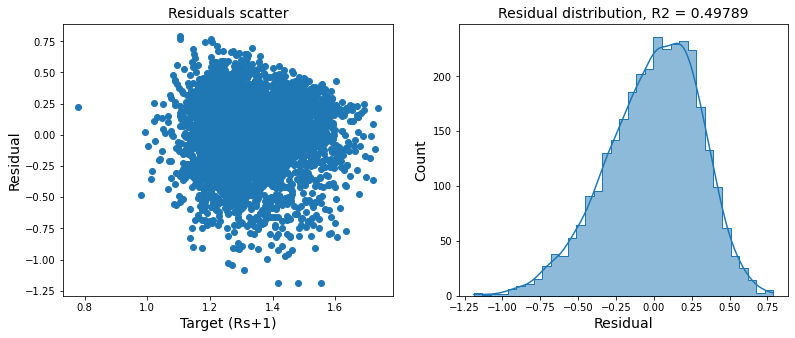

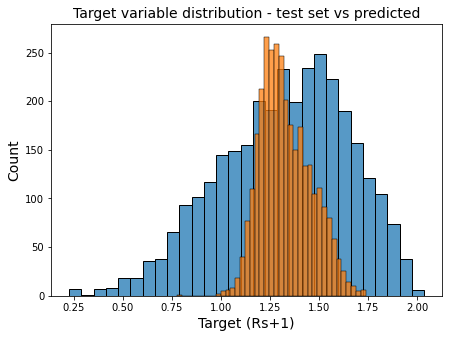

In [70]:
#Calculate the MSE for the model.
preds = model.predict(x_test)
print('MSE on the test set:  '+str(mean_squared_error(y_test, preds)))

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(13,5))
FS=14

#Scatter plot of residuals
residuals = (y_test-preds)
ax1.scatter(preds, residuals)
ax1.set_title('Residuals scatter',fontdict={'fontsize':FS})
ax1.set_xlabel('Target (Rs+1)',fontdict={'fontsize':FS})
ax1.set_ylabel('Residual',fontdict={'fontsize':FS})

#Distribution of residuals
sns.histplot(residuals, ax=ax2, element='step', kde='True' )
ax2.set_xlabel('Residual',fontdict={'fontsize':FS})
ax2.set_ylabel('Count',fontdict={'fontsize':FS})
ax2.set_title('Residual distribution, R2 = ' + 
              str(round(r2_score(y_train, model.predict(x_train)),5)),fontdict={'fontsize':FS})

#Test set vs predicted set target variable distribution
plt.figure(figsize=(7,5))
sns.histplot(y_test,color='tab:blue')
sns.histplot(preds,color='tab:orange')
plt.xlabel('Target (Rs+1)', fontsize=FS)
plt.ylabel('Count', fontsize=FS)
plt.title('Target variable distribution - test set vs predicted', fontsize=FS)

Our residuals are sligtly negatively skewed which we can see from the distribution and the distributions of our test data and predicted data. This is probably happening because low values of `Rs` are either due to noise when the number of data points used to calculate `Rs` is small or because low `Rs` values are heavily influenced by a feature that's not captured in MountainProject data (e.g. chronic injury, high workload outisde of climbing, etc). Either of these seem plausible. 

Now we will examine the importance of various features and the directionality of their effect. To do this using a gradient boosted tree model, we'll use the shap library. See below:

## Interpreting the model

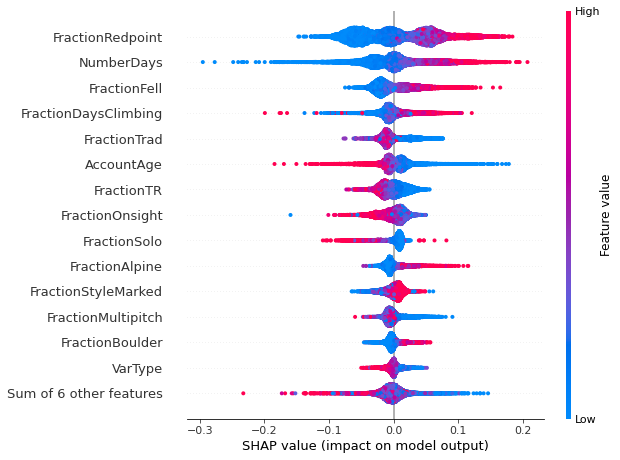

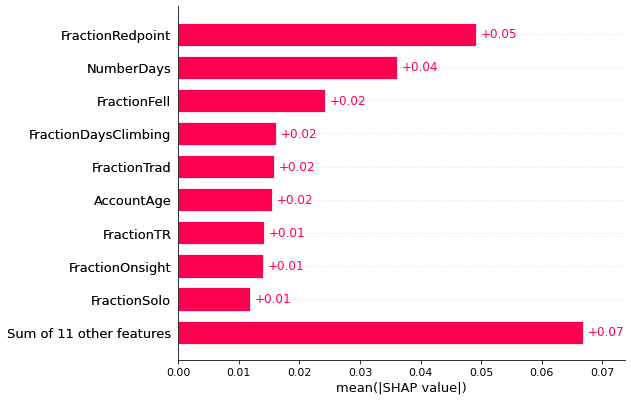

In [71]:
#Get SHAP values from model and feature set
explainer = shap.Explainer(model)
shap_values = explainer(X) 

#Plot shap values
shap.plots.beeswarm(shap_values, max_display=15)
shap.plots.bar(shap_values)



First, we can see that the amount of redpointing is the most influential feature for predicting progression, and that more redpointing leads to stronger progression. This is actually well known anecdotally in the climbing community. For most people, redpointing (in any subdiscipline) means that one is able to perform moves much closer to the limit of their ability, leading to greater strength and technique gains than climbing routes that easier for that person. This is confirmed by looking at two other features - `FractionOnsight` and `FractionFell`. We can see by looking at the beeswarm plot that the effect of `FractionOnsight` has the opposite directionality as `FractionRedpoint`(onsighting typically means climbing well below your limit) and `FractionFell` (a fall indicating that a climber is pushing themselves to their limit) has the same directionality as `FractionRedpoint`. <br/>

Second, we can see that features related to experience rank among the most influential. These are `NumberDays`, `FractionDaysClimbing`, and `AccountAge`. The former two tend to have a positive relationship with `Rs`, while `AccountAge` has a negative relationship. This makes sense in the context of dimminishing returns in climbing progression - very old accounts have probably "maxed out" their progression, while newer accounts are probably climbing at a lower grade and have more room to grow. Even so, maximizing the amount you're climbing for a given age should increase your progression.

Lastly, we see that `FractionTrad` and `FractionTR` have negative effects on the output, while `FractionBoulder` and `FractionAlpine` have positive effects. It makes sense for high levels of trad climbing to negatively affect progression, since it's much less common for climbers to push themselves in trad climbing due to the danger factor. Why is TRing negatively affecting progression? It might be that high levels of TRing are common with climbers who aren't very interested in pushing themselves, but rather just having fun. The sign of the effect in bouldering is anecdotally known to climbers - bouldering makes you stronger! Let's look at dependence plots for `FractionBoulder` and `FractionAlpine`:

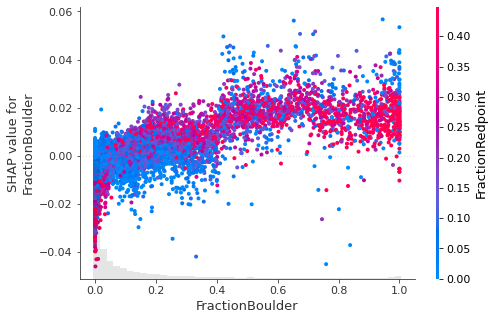

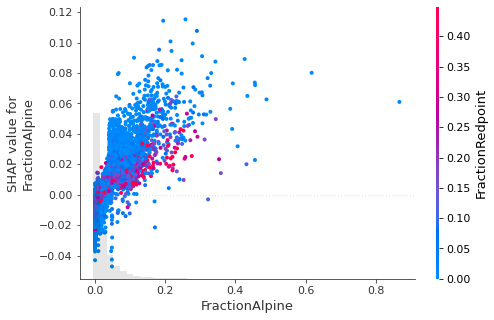

In [72]:
shap.plots.scatter(shap_values[:,"FractionBoulder"], color=shap_values)
shap.plots.scatter(shap_values[:,"FractionAlpine"], color=shap_values)

There is a broad distribution of `FractionBoulder` values, and the SHAP value increases from `FractionBoulder = 0` to plateau around `0.5`. So if you're trying to improve your roped climbing, it might not be worth it to spend >half your time bouldering. The dependence plot for `FractionAlpine` is interesting - somehow SHAP values are positive for `FractionAlpine > 0`, but mostly negative for `FractionAlpine = 0`, but the distribution of `FractionAlpine` is fairly narrow with some huge outliers. One hypothesis for what's going on is that users with high `FractionAlpine` can have higher `Rs` because alpine climbs tend to be lower grades, allowing more room for progression. Users with `FractionAlpine = 0` would be only climbing  single pitch routes/short multipitches and boulders, where they are likely to push grades higher and run into diminishing returns. 

This notebook was an initial forray into building a model based on this dataset. There are a lot more things one can do with this data, which I plan to explore in the future. One main area of improvement is in feature extraction and selection from the raw `userdata` file. This has proved very tricky due to the heterogenity and sampling biases in user tick data, but improvements can be made!